In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import optimizers as opt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from typing import List, Tuple, Dict, Union

%matplotlib inline
sns.set()

In [2]:
# utils
SEED = None

def set_random_seed(seed: int) -> int:
    """Sets the random seed for TensorFlow, numpy, python's random"""
    global SEED
    
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        SEED = seed
        print(f'Random seed {seed} set.')


def tf_global_norm(tensors: list, **kwargs):
    norms = [tf.norm(x, **kwargs) for x in tensors]
    return tf.sqrt(tf.reduce_sum([norm * norm for norm in norms]))


def free_mem():
    return gc.collect()


def dataset_from_tensors(tensors, batch_size: int, split=0.25, seed=SEED):
    total_size = tensors[-1].shape[0]
    val_size = int(total_size * split)
    train_size = total_size - val_size
    
    dataset = tf.data.Dataset.from_tensor_slices(tensors)
    dataset = dataset.shuffle(buffer_size=1024)

    training_set = dataset.take(train_size)
    training_set = training_set.batch(batch_size)
    
    validation_set = dataset.skip(train_size).take(val_size)
    validation_set = validation_set.batch(batch_size)
    
    free_mem()
    return training_set, validation_set


def assert_2d_array(x, last_dim=2):
    if x is None:
        return
    
    x = np.asarray(x)
    assert len(x.shape) == 2
    assert x.shape[-1] == last_dim


In [3]:
set_random_seed(42)

Random seed 42 set.


## Data
---

In [4]:
class Dataset:
    SIGNAL_PATH = os.path.join('data', 'signal.csv')
    BACKGROUND_PATH = os.path.join('data', 'background.csv')

    def __init__(self, x_scaler=None, m_scaler=None):
        self.signal = None
        self.background = None
        
        self.ds = None
        self.columns = []
        self.train_df = None
        self.test_df = None
        
        self.x_scaler = x_scaler
        self.m_scaler = m_scaler
        
        self.train_features = None
        self.test_features = None
        self.train_labels = None
        self.test_labels = None
        self.train_mass = None
        self.test_mass = None
        
        # keep sample weights
        self.weights_df = None
    
    def load(self, mass_intervals: Union[np.ndarray, List[tuple]] = None, test_size=0.2, seed=SEED):
        """Loads the signal+background data:
            - selects feature columns,
            - scales the data if a sklearn.Scaler was provided,
            - splits all the data into train and test sets,
            - allows to select which mass to keep: `mass_intervals` is an array  of shape (N, 2) which 
              specifies a "lower" and "upper" interval for the mass.
        """
        assert_2d_array(mass_intervals)
        
        if self.ds is not None:
            return

        print('[signal] loading...')
        self.signal = pd.read_csv(self.SIGNAL_PATH, dtype=np.float32, na_filter=False)
        
        print('[background] loading...')
        self.background = pd.read_csv(self.BACKGROUND_PATH, dtype=np.float32, na_filter=False)
        
        self.ds = pd.concat([self.signal, self.background])
        
        # select columns
        feature_columns = [
            "dimuon_deltar",
            "dimuon_deltaphi",
            "dimuon_deltaeta",
            "met_pt",
            "deltar_bjet1_dimuon",
            "deltapt_bjet1_dimuon",
            "deltaeta_bjet1_dimuon",
            "bjet_1_pt",
            "bjet_1_eta",
            "ljet_1_pt",
            "ljet_1_eta",
            "bjet_n",
            "ljet_n"]
        
        columns = dict(feature=feature_columns,
                       weight=['weight', 'PU_Weight'],
                       label=self.ds.columns[-1], mass=self.ds.columns[0])
        self.columns = columns
        
        # train-test split:
        self.train_df, self.test_df = train_test_split(self.ds, test_size=test_size, 
                                                       random_state=seed)
        # fit scaler (on "whole" training-set)
        if self.x_scaler is not None:
            self.x_scaler.fit(self.train_df[columns['feature']].values)
        
        if self.m_scaler is not None:
            self.m_scaler.fit(self.train_df[columns['mass']].unique().reshape((-1, 1)))
        
        # drop some mass
        if isinstance(mass_intervals, (list, np.ndarray)):
            self._select_mass(intervals=mass_intervals)
            
            self.train_df, self.test_df = train_test_split(self.ds, test_size=test_size, 
                                                           random_state=seed)
            free_mem()

        # select series
        self.train_features = self.train_df[columns['feature']]
        self.train_labels = self.train_df[columns['label']]
        self.train_mass = self.train_df[columns['mass']]
        
        self.test_features = self.test_df[columns['feature']]
        self.test_labels = self.test_df[columns['label']]
        self.test_mass = self.test_df[columns['mass']]
        
        # select "sample weights" for training data only
        self.weights_df = self.train_df[columns['weight']]
        
        print('dataset loaded.')
        free_mem()
    
    def get(self, mask=None) -> tuple:
        if mask is not None:
            features = self.test_features[mask].values
            labels = self.test_labels[mask].values
            mass = self.test_mass[mask].values
        else:
            features = self.train_features.values
            labels = self.train_labels.values
            mass = self.train_mass.values

        mass = mass.reshape((-1, 1))
        labels = labels.reshape((-1, 1))

        if self.x_scaler is not None:
            features = self.x_scaler.transform(features)
        
        if self.m_scaler is not None:
            mass = self.m_scaler.transform(mass)

        x = dict(x=features, m=mass)
        y = labels
        
        free_mem()
        return x, y
    
    def get_by_mass(self, interval: Union[list, tuple]) -> dict:
        mass_low, mass_high = interval
        
        return self.get(mask=(self.test_mass >= mass_low) & (self.test_mass < mass_high))
    
    def _select_mass(self, intervals: Union[list, np.ndarray]):
        """Selects only the given mass from the dataframe"""
        mask = np.full(shape=(len(self.ds),), fill_value=False)
        
        # get at which index there are the requested mass
        for (m_low, m_upp) in intervals:
            mask |= (self.ds['mA'] >= m_low) & (self.ds['mA'] < m_upp)

        # select data
        self.ds = self.ds[mask]
        free_mem()
        

## Models definition
---

In [5]:
#@title
"""Dynamic step-dependent parameters: used as learning rate schedules"""

from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


class DynamicParameter:
    """Interface for learning rate schedule wrappers as dynamic-parameters"""
    def __init__(self):
        self._value = tf.Variable(initial_value=0.0, trainable=False, dtype=tf.float32)
        self.step = tf.Variable(initial_value=0, trainable=False, dtype=tf.int32)

    @property
    def value(self):
        return self._value.value()

    @property
    def variable(self):
        return self._value

    @value.setter
    def value(self, value):
        self._value.assign(value)

    @staticmethod
    def create(value: Union[float, int, LearningRateSchedule], **kwargs):
        """Converts a floating or LearningRateSchedule `value` into a DynamicParameter object"""
        if isinstance(value, (DynamicParameter, ScheduleWrapper)):
            return value

        if isinstance(value, (float, int)):
            return ConstantParameter(value)

        if isinstance(value, LearningRateSchedule):
            return ScheduleWrapper(schedule=value, **kwargs)

        raise ValueError(f'Parameter "value" should be not {type(value)}.')

    def __call__(self, *args, **kwargs):
        return self.value

    def __sub__(self, other):
        self._value.assign_sub(other)

    def __add__(self, other):
        self._value.assign_add(other)

    def serialize(self) -> dict:
        return dict(step=int(self.step.value()))

    def on_step(self):
        self.step.assign_add(delta=1)

    def load(self, config: dict):
        self.step.assign(value=config.get('step', 0))

    def get_config(self) -> dict:
        return {}


class ScheduleWrapper(LearningRateSchedule, DynamicParameter):
    """A wrapper for built-in tf.keras' learning rate schedules"""
    def __init__(self, schedule: LearningRateSchedule, min_value=1e-7, max_value=None):
        super().__init__()
        self.schedule = schedule
        self.min_value = tf.constant(min_value, dtype=tf.float32)

        if isinstance(max_value, (float, int)):
            self.max_value = tf.constant(max_value, dtype=tf.float32)
        else:
            self.max_value = None

        self._value.assign(value=self.schedule.initial_learning_rate)

    def __call__(self, *args, **kwargs):
        self.value = tf.maximum(self.min_value, self.schedule.__call__(self.step))

        if self.max_value:
            self.value = tf.minimum(self.value, self.max_value)

        return self.value

    def get_config(self) -> dict:
        return self.schedule.get_config()


class ConstantParameter(DynamicParameter):
    """A constant learning rate schedule that wraps a constant float learning rate value"""
    def __init__(self, value: float):
        super().__init__()
        self.value = value

    def __call__(self, *args, **kwargs):
        return self.value

    def serialize(self) -> dict:
        return {}


class ExponentialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, staircase=False, min_value=0.0, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=bool(staircase)),
                         min_value=min_value, max_value=max_value)


class StepDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, min_value=1e-7, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=True),
                         min_value=min_value, max_value=max_value)


class LinearDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=1.0, cycle=bool(cycle)))


class PolynomialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, power=1.0, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=power, cycle=bool(cycle)))


In [33]:
class PNN(Model):
    """A Parametric Neural Network (PNN) model with various way to condition *only* the input layer"""
    
    def __init__(self, input_shapes: dict, weight_decay=0.0, **kwargs):
        name = kwargs.pop('name', 'ParametricNN')
        
        inputs, outputs = self.structure(input_shapes, **kwargs)
        super().__init__(inputs, outputs, name=name)

        self.lr = None
        
        self.weight_decay = tf.constant(weight_decay, dtype=tf.float32)
        self.should_decay_weights = self.weight_decay > 0.0
        
    def compile(self, optimizer_class=opt.Adam, loss='binary_crossentropy', metrics=None, lr=0.001, **kwargs):
        self.lr = DynamicParameter.create(value=lr)
        optimizer = optimizer_class(learning_rate=self.lr, **kwargs)

        super().compile(optimizer, loss, metrics)

    def structure(self, shapes: dict, units=128, num_layers=2, activation='relu', conditioning='concat',
                  dropout=0.0, **kwargs) -> tuple:
        inspect = kwargs.pop('inspect', False)
        apply_dropout = dropout > 0.0
        
        inputs = self.inputs_from_shapes(shapes)
        
        if conditioning == 'paper':
            # input concatenation
            x = concatenate(list(inputs.values()))
            
        elif conditioning == 'concat':
            # input concatenation + linear combination
            x = concatenate(list(inputs.values()))
            x = Dense(units=units, activation='linear', name='linear', **kwargs)(x)

        elif conditioning == 'scaling':
            # linear combination (m) + element-wise multiplication (x)
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='linear', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'sigmoid':
            # sigmoidal-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='sigmoid', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'softmax':
            # softmax-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='softmax', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'affine':
            # apply an affine transformation y = scale(m) * x + bias(m)
            x = inputs['x']
            m = inputs['m']

            scale = Dense(units=x.shape[-1], activation='linear', 
                            name='scale', **kwargs)(m)

            bias =  Dense(units=x.shape[-1], activation='linear', 
                            name='bias', **kwargs)(m)

            x = multiply([x, scale])
            x = add([x, bias])
        else:
            x = inputs['x']

        if conditioning != 'paper' and apply_dropout:
            x = Dropout(rate=dropout)(x)
            
        for _ in range(num_layers):
            x = Dense(units=units, activation=activation, **kwargs)(x)
            
            if apply_dropout:
                x = Dropout(rate=dropout)(x)
        
        outputs = Dense(units=1, activation='sigmoid', **kwargs)(x)

        if inspect:
            return inputs, [outputs, x]

        return inputs, outputs
    
    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]
        
        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
            sample_weight = tf.ones_like(labels)
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            loss = self.compiled_loss(labels, classes, sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
            
        global_norm, lr = self.apply_gradients(tape, loss)
        self.lr.on_step()

        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2-loss'] = l2_loss
        
        return debug
    
    def apply_gradients(self, tape, loss):
        variables = self.trainable_variables

        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))

        return tf_global_norm(grads), self.lr.value
    
    def decay_weights(self) -> tuple:
        weight_norm = tf_global_norm(self.trainable_variables)
            
        if self.should_decay_weights:
            l2_loss = weight_norm * self.weight_decay
        else:
            weight_norm = tf.stop_gradient(weight_norm)
            l2_loss = 0.0
        
        return weight_norm, l2_loss
    
    def update_metrics(self, true, predicted, sample_weight=None) -> dict:
        self.compiled_metrics.update_state(true, predicted, sample_weight=sample_weight)

        return {metric.name: metric.result() for metric in self.metrics}

    @staticmethod
    def inputs_from_shapes(shapes: Dict[str, tuple]) -> Dict[str, Input]:
        return {name: Input(shape=shape, name=name) for name, shape in shapes.items()}


In [34]:
class AffineConditioning(Layer):
    """Affine transform-based conditioning layer"""

    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.kwargs = kwargs

        self.dense_scale: Dense = None
        self.dense_bias: Dense = None

        self.multiply = Multiply()
        self.add = Add()

    def build(self, input_shape):
        shape, _ = input_shape
        self.dense_scale = Dense(units=shape[-1], activation='linear', **self.kwargs)
        self.dense_bias = Dense(units=shape[-1], activation='linear', **self.kwargs)

    def call(self, inputs, **kwargs):
        assert isinstance(inputs, (list, tuple))
        assert len(inputs) == 2

        # condition input `x` on `z`
        x, z = inputs

        scale = self.dense_scale(z)
        bias = self.dense_bias(z)

        # apply affine transformation, i.e. y = scale(z) * x + bias(z)
        y = self.multiply([x, scale])
        y = self.add([y, bias])
        return y


class AffinePNN(PNN):
    """A PNN that uses Affine conditioning for all layers, not only the Input layer"""
    
    def __init__(self, *args, weight_decay=0.0, mass_weights=None, mass_scaler=None, 
                 mass_intervals: Union[np.ndarray, List[tuple]] = None, **kwargs):
        super().__init__(*args, weight_decay=weight_decay, **kwargs)
        
        # mass weights       
        if isinstance(mass_weights, (list, tuple, np.ndarray)):
            assert len(mass_weights) == len(mass_intervals)
            
            intervals = np.asarray(mass_intervals)
            assert_2d_array(intervals)
            
            self.mass_low = intervals[:, 0]
            self.mass_high = intervals[:, 1]
            
            # scale bins as input mass is scaled
            if mass_scaler is not None:
                self.mass_low = mass_scaler.transform(np.reshape(self.mass_low, newshape=(-1, 1)))
                self.mass_low = tf.squeeze(self.mass_low)
                
                self.mass_high = mass_scaler.transform(np.reshape(self.mass_high, newshape=(-1, 1)))
                self.mass_high = tf.squeeze(self.mass_high)
            
            self.mass_low = tf.cast(self.mass_low, dtype=tf.float32)
            self.mass_high = tf.cast(self.mass_high, dtype=tf.float32)
            
            self.mass_weights = tf.squeeze(mass_weights)
        else:
            self.mass_weights = None
        
    def structure(self, shapes: dict, activation='relu', dropout=0.0, **kwargs) -> tuple:
        inputs = self.inputs_from_shapes(shapes)
        
        apply_dropout = dropout > 0.0
        units = kwargs.pop('units')
        
        x = inputs['x']
        m = inputs['m']
        
        for i, unit in enumerate(units):
            x = Dense(units=unit, activation=activation, **kwargs)(x)
            x = AffineConditioning(name=f'affine-{i}')([x, m])
            
            if apply_dropout:
                x = Dropout(rate=dropout)(x)
        
        out = Dense(units=1, activation='sigmoid', name='classes', **kwargs)(x)
        return inputs, out
    
    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]

        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
        
            sample_weight = self.get_mass_weights(features=x, labels=labels)
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            
            loss = self.compiled_loss(labels, classes, 
                                      sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
        
        global_norm, lr = self.apply_gradients(tape, total_loss)
        self.lr.on_step()
        
        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['total_loss'] = tf.reduce_mean(total_loss)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2_loss'] = l2_loss
    
        return debug
    
    def get_mass_weights(self, features, labels):
        if ('m' in features) and tf.is_tensor(self.mass_weights):
            mass = tf.cast(features['m'], dtype=tf.float32)
            
            # find which mass falls in which bin
            mask = (mass >= self.mass_low) & (mass < self.mass_high)
            bins = tf.argmax(tf.cast(mask, dtype=tf.int32), axis=-1)

            # index by bin and label
            indices = tf.concat([bins[:, None], tf.cast(labels, dtype=tf.int64)], axis=-1)

            # retrieve weights
            mass_weights = tf.gather_nd(self.mass_weights, indices)
            mass_weights = tf.cast(mass_weights, dtype=tf.float32)[:, None]
        else:
            mass_weights = tf.ones_like(labels)
            
        return mass_weights
        

In [35]:
class MassValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, data: tuple, batch_size: int, early_stop: Union[bool, int] = False):
        super().__init__()
        
        self.dataset = tf.data.Dataset.from_tensor_slices(data)
        self.dataset = self.dataset.batch(batch_size)
        
        self.auc = tf.keras.metrics.AUC()
        
        # early stopping based on AUC value
        if isinstance(early_stop, int):
            self.should_early_stop = True
            self.patience = early_stop
            
            self.stopped_epoch = 0
            self.best_auc = np.Inf
            self.wait = 0
            self.best_weights = None
        else:
            self.should_early_stop = False
    
    def on_train_begin(self, logs=None):
        if not self.should_early_stop:
            return
        
        self.stopped_epoch = 0
        self.best_auc = np.Inf
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        for (x, labels) in self.dataset:
            classes = self.model(x, training=False)
            
            self.auc.update_state(labels, classes)
        
        auc = self.auc.result()
        logs['mass_auc'] = np.round(auc, 4)
        
        if not self.should_early_stop:
            return
        
        if np.greater(auc, self.best_auc):
            self.best_auc = auc
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
                # restore model weights
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self, logs=None):
        if self.should_early_stop and (self.stopped_epoch > 0):
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


## Reproduce Paper Results
* WARNING: `Dataset` class will load a dataset that is different from the one used in the paper
---

In [8]:
# load data
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()

x_train, y_train = data.get()

[signal] loading...
[background] loading...
dataset loaded.


In [9]:
batch_size = 100
val_split = 0.25

In [10]:
# define model architecture as in Baldi t al.
weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=42)

paper_model = PNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), units=500, num_layers=5, 
                  conditioning='paper', kernel_initializer=weight_init)

paper_model.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          7500        concatenate[0][0]     

In [13]:
# define optimizer and decaying learning rate schedule
decay_steps = int(y_train.shape[0] * (1.0 - val_split) / batch_size)

paper_lr_schedule = StepDecay(0.1, steps=decay_steps, rate=0.89)

paper_model.compile(optimizer_class=opt.SGD, momentum=0.5,
                    metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                    lr=paper_lr_schedule)

In [ ]:
h = paper_model.fit(x=x_train, y=y_train, batch_size=batch_size,
                    validation_split=val_split,
                    epochs=10)  # the authors train for 200 epochs

In [14]:
# sample_weight = np.ones_like(y_train)  # CHANGE AS NEEDED!
sample_weight = data.weights_df['PU_Weight']

train_dataset, val_dataset = dataset_from_tensors((x_train, y_train, sample_weight), batch_size, split=val_split)

In [ ]:
# training with sample weights (ALWAYS USE `dataset_from_tensors`!!)

h = paper_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [ ]:
paper_model.save_weights('my_weights/paper/weights')

### Training New Model (AffinePNN)
---
* Load training data

In [ ]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()

x_train, y_train = data.get()

In [8]:
batch_size = 100
val_split = 0.25

* Affine-conditioned Parametric NN

In [12]:
# definition
model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                  units=[300, 150, 100, 50])
model.summary()

# model.load_weights('my_weights/affine_model/weights')

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
              metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
              lr=lr_schedule)

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense[0][0]                      
                                                                 m[0][0]               

In [ ]:
# training
_ = model.fit(x=x_train, y=y_train, batch_size=batch_size,
              validation_split=val_split, epochs=10)

In [73]:
model.save_weights('my_weights/affine_model/weights')

In [13]:
model.load_weights('my_weights/affine_model/weights')

* Avoid and quantify **"mass overfitting"**:

In [20]:
# make two mass intervals: 
#  - one with all itervals minus one, 
#  - and the other with that one, to be used as "mass-validation set".
train_intervals = [
    (105, 115),  # 10
    (115, 125),
    (125, 135),
    (135, 145),
    (145, 155),
    (155, 165),
    (165, 175),
    (175, 185),
    (185, 195),
    (195, 205),
    (205, 212.5),  # 25
    (212.5, 237.5),
    (237.5, 262.5),
    (262.5, 289.5),
    (289.5, 325),
    (325, 375),  # 50
    (375, 425),
    (425, 475),
    (475, 550),  # 100
#     (550, 650),
    (650, 750),
    (750, 850),
    (850, 950),
    (950, 1000)]

val_intervals = [(550, 650)]

In [12]:
# load training data
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(mass_intervals=train_intervals)

free_mem()
x_train, y_train = data.get()

# load validation data
val_data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
val_data.load(mass_intervals=val_intervals)

free_mem()
x_val, y_val = val_data.get()

[signal] loading...
[background] loading...
dataset loaded.
[signal] loading...
[background] loading...
dataset loaded.


In [ ]:
# make model
batch_size = 100
val_split = 0.25

model_ovf = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                      units=[300, 150, 100, 50], dropout=0.0)

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

model_ovf.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                  metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                  lr=lr_schedule)

callback = MassValidationCallback(data=(x_val, y_val), batch_size=batch_size, early_stop=3)

# fit
_ = model_ovf.fit(x=x_train, y=y_train, batch_size=batch_size,
                  validation_split=val_split, epochs=10, callbacks=[callback])

* Training with `class_weight` (dict):

In [24]:
# discover how imbalanced the classes are:

BKG_LABEL = 0
SIG_LABEL = 1

class_count = data.ds.shape[0]  # total number of samples

class_weights = {
    BKG_LABEL: data.signal.shape[0] / class_count,  # weight for background
    SIG_LABEL: data.background.shape[0] / class_count  # weight for signal
}

class_weights

{0: 0.43519348072636826, 1: 0.5648065192736317}

In [25]:
cw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50])
# cw_model.summary()

decay_steps = int(y_train.shape[0] / batch_size * 0.75)
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75, min_value=1e-5)

cw_model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_weights/affine_class_weights/weights',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

_ = cw_model.fit(x=x_train, y=y_train, batch_size=batch_size, class_weight=class_weights,
                 validation_split=val_split, epochs=10, callbacks=[callback])

Epoch 1/20
27405/27405 [==============================] - 306s 11ms/step - loss: 0.1296 - binary_accuracy: 0.7490 - auc_1: 0.8496 - precision_1: 0.6805 - recall_1: 0.7991 - total_loss: 0.2304 - lr: 9.9998e-04 - norm: 0.4942 - weight-norm: 24.9302 - l2_loss: 0.0000e+00 - val_loss: 0.3571 - val_binary_accuracy: 0.8364 - val_auc_1: 0.9170 - val_precision_1: 0.7873 - val_recall_1: 0.8545
Epoch 2/20
27405/27405 [==============================] - 288s 11ms/step - loss: 0.1494 - binary_accuracy: 0.8488 - auc_1: 0.9281 - precision_1: 0.7860 - recall_1: 0.8972 - total_loss: 0.1639 - lr: 7.4998e-04 - norm: 0.8999 - weight-norm: 31.5116 - l2_loss: 0.0000e+00 - val_loss: 0.3187 - val_binary_accuracy: 0.8605 - val_auc_1: 0.9343 - val_precision_1: 0.8170 - val_recall_1: 0.8753
Epoch 3/20
27405/27405 [==============================] - 252s 9ms/step - loss: 0.1256 - binary_accuracy: 0.8658 - auc_1: 0.9415 - precision_1: 0.8061 - recall_1: 0.9112 - total_loss: 0.1480 - lr: 5.6248e-04 - norm: 1.4050 - w

KeyboardInterrupt: 

In [26]:
cw_model.save_weights('my_weights/affine_class_weights/weights')

* Training with `sample_weight`:

In [ ]:
sw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50])

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

sw_model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

# sample_weights
sample_weight = data.weights_df['PU_Weight']
train_set, val_set = dataset_from_tensors((x_train, y_train, sample_weight), batch_size, split=val_split)

_ = sw_model.fit(train_set, validation_data=val_set, epochs=10)

* Training with `mass_weights` (list of tuples, or 2D-array) requires:
    - A 2D-array of intervals, e.g. $[(100, 200), (225, 275), ...]$, in this way the bin size is not fixed.

In [52]:
# discover mass imbalance

def get_mass_weights(intervals: Union[np.ndarray, List[tuple]]):
    """Returns an np.array in which for each bin there are two weights: one for BKG, and the other for SIG"""
    assert_2d_array(intervals)
    
    intervals = np.asarray(intervals)
    
    mass_low = intervals[:, 0][None, :]
    mass_upp = intervals[:, 1][None, :]
    
    mA = data.ds['mA'].values[:, None]
    label = data.ds['type'].values
    
    # find which mass is in which bin
    mask = (mA >= mass_low) & (mA < mass_upp)
    
    bins = np.argmax(mask, axis=-1)
    
    # make a DataFrame of bins and respective labels
    df = pd.DataFrame({'bin': bins, 'label': label})
    
    # count bins in signal and bkg
    counts = df.groupby(['bin', 'label']).size()
    
    # compute weights for each bin and label
    weights = []
    
    for bin_ in range(len(intervals)):
        count = counts[bin_].values
        
        w = count / count.sum()
        weights.append(1.0 - w)
    
    free_mem()
    return np.array(weights)


In [56]:
# example of mass weight for fixed bins
mass_intervals = np.stack(
    [np.arange(100, 1000, 100), np.arange(200, 1100, 100)], axis=-1)

print(mass_intervals, mass_intervals.shape)

mass_weights = get_mass_weights(mass_intervals)
mass_weights

[[ 100  200]
 [ 200  300]
 [ 300  400]
 [ 400  500]
 [ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]] (9, 2)


array([[0.58584697, 0.41415303],
       [0.36029691, 0.63970309],
       [0.51682819, 0.48317181],
       [0.52567844, 0.47432156],
       [0.35061193, 0.64938807],
       [0.36356651, 0.63643349],
       [0.36509763, 0.63490237],
       [0.36672709, 0.63327291],
       [0.36624129, 0.63375871]])

In [ ]:
mw_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                     units=[300, 150, 100, 50], mass_scaler=data.m_scaler,
                     mass_intervals=mass_intervals, mass_weights=mass_weights)
# mw_model.summary()

decay_steps = int(y_train.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

mw_model.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                 metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                 lr=lr_schedule)

_ = mw_model.fit(x=x_train, y=y_train, batch_size=batch_size,
                 validation_split=val_split, epochs=10)

### Testing
* Compare AUC metric towards various mass [`auc_vs_mass`]
* Compare AUC metric versus a constant mass (either seen or not during training) [`auc_vs_no_mass`]
* Plot all the metrics w.r.t. the mass [`metrics_vs_mass`]
* Compare AUC vs mass when some (or all) features from $x$ are dropped [`auc_vs_mass_no_features`]
* Generalization capability by interpolation between unknown (not trained on) mass
---

In [10]:
def mean_mass(intervals):
    assert_2d_array(intervals)
    return np.mean(intervals, axis=1)

In [11]:
test_intervals = np.stack(
    [np.arange(50, 1000, 100), np.arange(150, 1100, 100)], axis=-1)

test_intervals, mean_mass(test_intervals)

(array([[  50,  150],
        [ 150,  250],
        [ 250,  350],
        [ 350,  450],
        [ 450,  550],
        [ 550,  650],
        [ 650,  750],
        [ 750,  850],
        [ 850,  950],
        [ 950, 1050]]),
 array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
        1000.]))

In [12]:
def check_underflow(metric, control_metric) -> float:
    if metric == 0.0 and control_metric >= 0.9:
        return 1.0  # underflow occurred (metric would be wrongly 0.0)
    
    return metric  # no uderflow


def auc_vs_mass(model, dataset, auc_index: int, mass_intervals: Union[np.ndarray, List[tuple]], figsize=(26, 20), 
                verbose=1):
    assert_2d_array(mass_intervals)
    plt.figure(figsize=figsize)

    auc = []
    mass = mean_mass(mass_intervals)
    
    for interval in mass_intervals:
        x, y = dataset.get_by_mass(interval)
        
        print(f'Mass: {np.round(interval, 2)} -> {round(np.mean(interval), 2)}')
        score = model.evaluate(x=x, y=y, batch_size=128, verbose=verbose)
        
        auc_score = round(score[auc_index], 4)
        auc.append(check_underflow(auc_score, score[1]))
    
    
    plt.title(f'AUC vs Mass')
    plt.plot(mass, auc)
    plt.scatter(mass, auc, s=50, color='b')
    
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.show()
    return auc


def auc_vs_no_mass(model, dataset, auc_index: int, mass_intervals: Union[np.ndarray, List[tuple]], const=[0], 
                   figsize=(26, 20), verbose=1):
    assert_2d_array(mass_intervals)
    plt.figure(figsize=figsize)

    mass = mean_mass(mass_intervals)
    auc = {m: [] for m in const}

    for interval in mass_intervals:
        x, y = dataset.get_by_mass(interval)
        
        for fake_m in const:
            x['m'] = np.ones_like(x['m']) * fake_m
        
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=verbose)
            
            auc_score = round(score[auc_index], 4)
            auc[fake_m].append(check_underflow(auc_score, score[1]))
    
    plt.title(f'AUC vs Mass')
    
    for fake_m in const:
        plt.plot(mass, auc[fake_m], label=f'm-{round(fake_m, 2)}')
        plt.scatter(mass, auc[fake_m], s=50)
        
    plt.legend(loc='best')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.show()
    return auc



# def metrics_vs_mass(models: dict, dataset, metrics: list, rows: int, cols: int, figsize=(26, 20)):
#     plt.figure(figsize=figsize)

#     mass = list(dataset.unique_mass)
#     scores = {key: [[] for _ in range(len(metrics))] for key in models.keys()}

#     for m in dataset.unique_mass:
#         x, y = dataset.get_by_mass(m)
        
#         for label, model in models.items():
#             score = model.evaluate(x=x, y=y, batch_size=128, verbose=1)
#             # print(f'[m={m}] {str(score)}')

#             for i, value in enumerate(score):
#                 scores[label][i].append(value)

#     for i, name in enumerate(metrics):
#         plt.subplot(rows, cols, i + 1)
#         plt.title(f'{name} vs mass')

#         for label in models.keys():
#             plt.plot(mass, scores[label][i], label=label)
        
#         plt.legend(loc='best')
#         plt.ylabel(name)
#         plt.xlabel('Mass')
    
#     plt.show()
#     return scores


Mass: [ 50 150]
Mass: [150 250]
Mass: [250 350]
Mass: [350 450]
Mass: [450 550]
Mass: [550 650]
Mass: [650 750]
Mass: [750 850]
Mass: [850 950]
Mass: [ 950 1050]


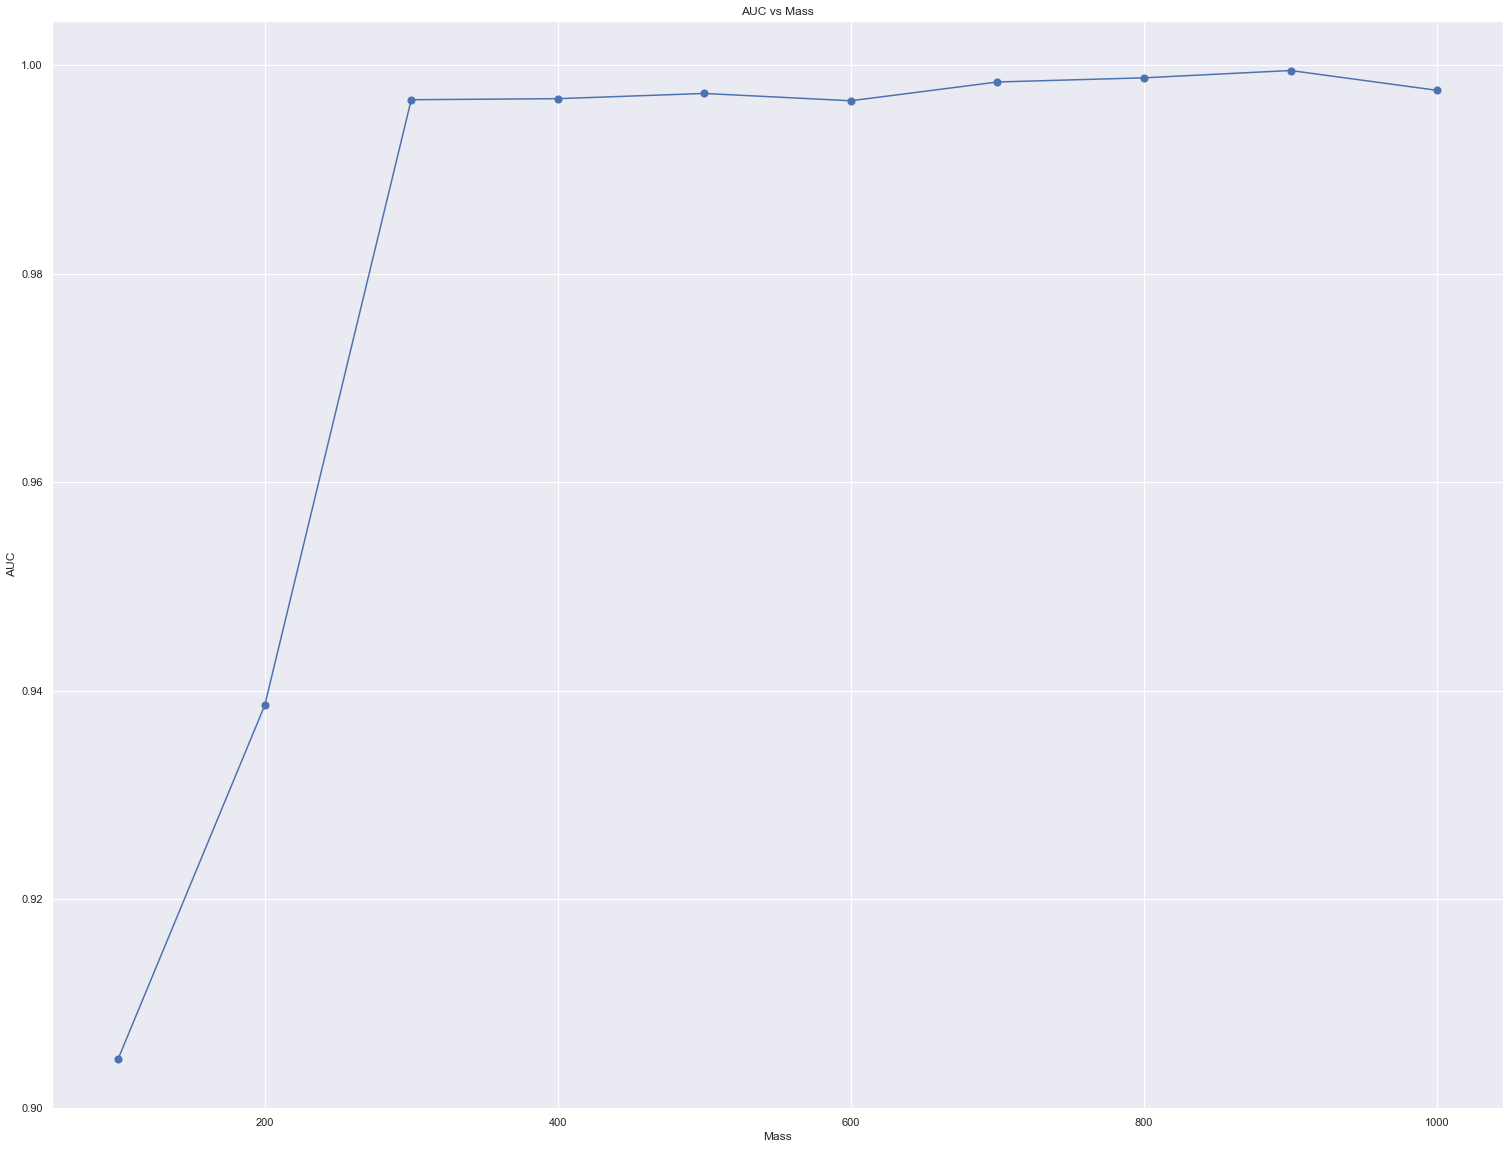

[0.9047,
 0.9386,
 0.9967,
 0.9968,
 0.9973,
 0.9966,
 0.9984,
 0.9988,
 0.9995,
 0.9976]

In [90]:
auc_vs_mass(model, data, auc_index=2, mass_intervals=test_intervals, verbose=0)

In [17]:
# training mass
sig_mass = data.signal['mA'].unique()
sig_mass

array([ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
        200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
        600.,  700.,  800.,  900., 1000.], dtype=float32)

* Signal mass

In [13]:
# non-overlapping (without "holes") signal mass intervals
non_sig_intervals = [
    (105, 115),  # 10
    (115, 125),
    (125, 135),
    (135, 145),
    (145, 155),
    (155, 165),
    (165, 175),
    (175, 185),
    (185, 195),
    (195, 205),
    (205, 212.5),  # 25
    (212.5, 237.5),
    (237.5, 262.5),
    (262.5, 289.5),
    (289.5, 325),
    (325, 375),  # 50
    (375, 425),
    (425, 475),
    (475, 550),  # 100
    (550, 650),
    (650, 750),
    (750, 850),
    (850, 950),
    (950, 1000)]

In [14]:
# overlapping signal mass intervals
overlap_sig_intervals = []

for i in range(len(sig_mass) - 1):
    if i == 0:
        lo = 100.0
    else:
        lo = sig_mass[i - 1]

    up = sig_mass[i + 1]
    
    overlap_sig_intervals.append((lo, up))

overlap_sig_intervals

NameError: name 'sig_mass' is not defined

In [20]:
# use +-10 for overllapping intervals
sig_intervals = np.stack(
    [data.signal['mA'].unique() - 5, data.signal['mA'].unique() + 5], axis=-1)

sig_intervals, mean_mass(sig_intervals)

(array([[ 105.,  115.],
        [ 115.,  125.],
        [ 125.,  135.],
        [ 135.,  145.],
        [ 145.,  155.],
        [ 155.,  165.],
        [ 165.,  175.],
        [ 175.,  185.],
        [ 185.,  195.],
        [ 195.,  205.],
        [ 220.,  230.],
        [ 245.,  255.],
        [ 270.,  280.],
        [ 295.,  305.],
        [ 345.,  355.],
        [ 395.,  405.],
        [ 445.,  455.],
        [ 495.,  505.],
        [ 595.,  605.],
        [ 695.,  705.],
        [ 795.,  805.],
        [ 895.,  905.],
        [ 995., 1005.]], dtype=float32),
 array([ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
         200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
         600.,  700.,  800.,  900., 1000.], dtype=float32))

Mass: [105 115] -> 110.0
Mass: [115 125] -> 120.0
Mass: [125 135] -> 130.0
Mass: [135 145] -> 140.0
Mass: [145 155] -> 150.0
Mass: [155 165] -> 160.0
Mass: [165 175] -> 170.0
Mass: [175 185] -> 180.0
Mass: [185 195] -> 190.0
Mass: [195 205] -> 200.0
Mass: [205.  212.5] -> 208.75
Mass: [212.5 237.5] -> 225.0
Mass: [237.5 262.5] -> 250.0
Mass: [262.5 289.5] -> 276.0
Mass: [289.5 325. ] -> 307.25
Mass: [325 375] -> 350.0
Mass: [375 425] -> 400.0
Mass: [425 475] -> 450.0
Mass: [475 550] -> 512.5
Mass: [550 650] -> 600.0
Mass: [650 750] -> 700.0
Mass: [750 850] -> 800.0
Mass: [850 950] -> 900.0
Mass: [ 950 1000] -> 975.0


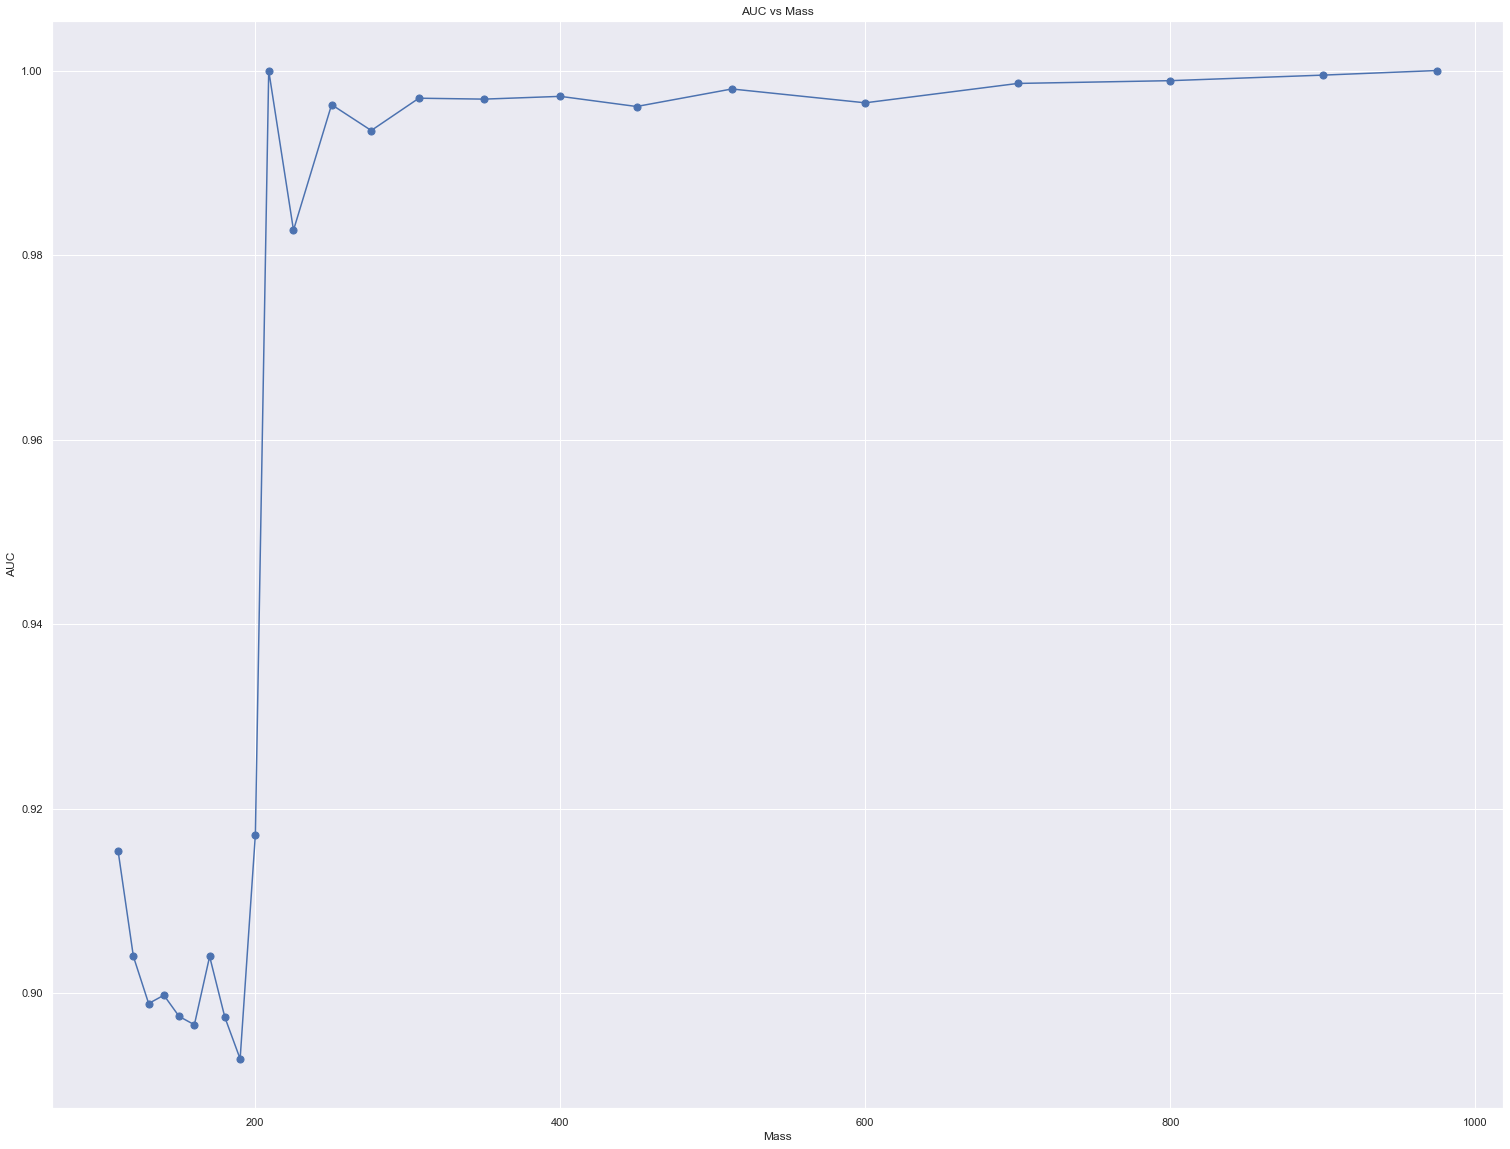

[0.9154,
 0.904,
 0.8989,
 0.8998,
 0.8975,
 0.8966,
 0.904,
 0.8974,
 0.8929,
 0.9172,
 1.0,
 0.9827,
 0.9963,
 0.9935,
 0.997,
 0.9969,
 0.9972,
 0.9961,
 0.998,
 0.9965,
 0.9986,
 0.9989,
 0.9995,
 1.0]

In [22]:
# test on *overlapping* signal mass -> AUC curve seems to be more smooth
auc_vs_mass(model, data, auc_index=2, mass_intervals=non_sig_intervals, verbose=0)

Mass: [100. 120.] -> 110.0
Mass: [110. 130.] -> 120.0
Mass: [120. 140.] -> 130.0
Mass: [130. 150.] -> 140.0
Mass: [140. 160.] -> 150.0
Mass: [150. 170.] -> 160.0
Mass: [160. 180.] -> 170.0
Mass: [170. 190.] -> 180.0
Mass: [180. 200.] -> 190.0
Mass: [190. 225.] -> 207.5
Mass: [200. 250.] -> 225.0
Mass: [225. 275.] -> 250.0
Mass: [250. 300.] -> 275.0
Mass: [275. 350.] -> 312.5
Mass: [300. 400.] -> 350.0
Mass: [350. 450.] -> 400.0
Mass: [400. 500.] -> 450.0
Mass: [450. 600.] -> 525.0
Mass: [500. 700.] -> 600.0
Mass: [600. 800.] -> 700.0
Mass: [700. 900.] -> 800.0
Mass: [ 800. 1000.] -> 900.0


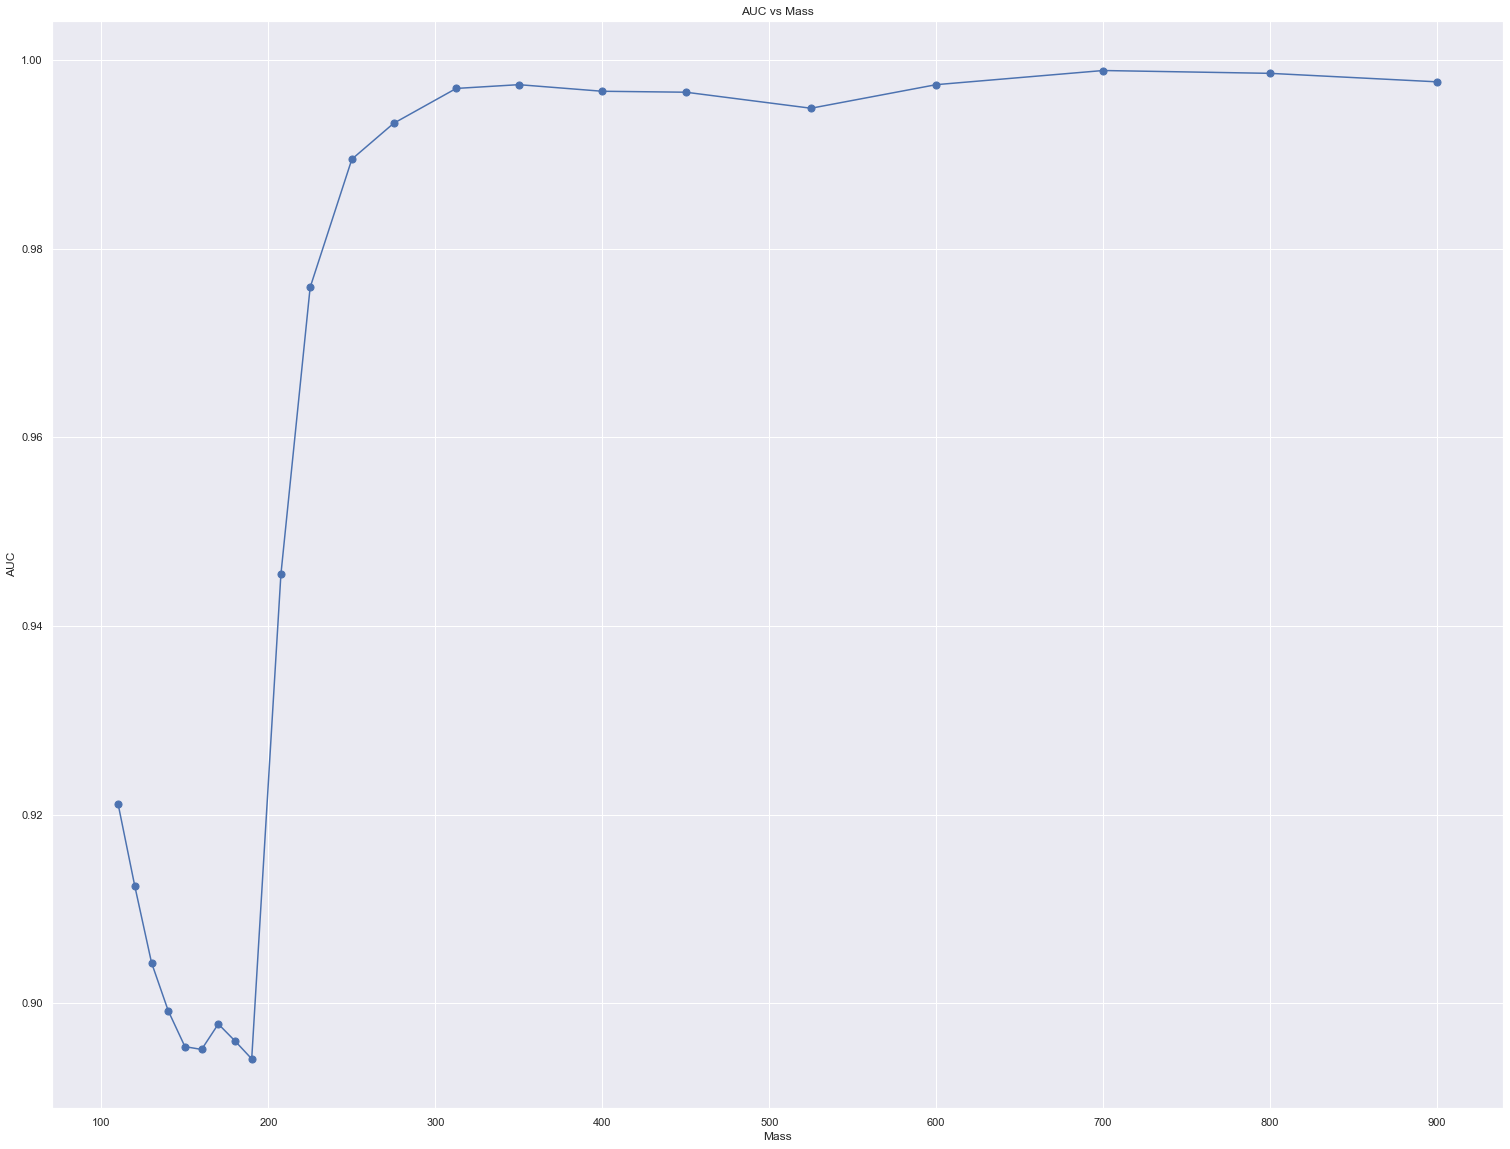

[0.9211,
 0.9124,
 0.9043,
 0.8992,
 0.8954,
 0.8951,
 0.8978,
 0.896,
 0.8941,
 0.9455,
 0.9759,
 0.9895,
 0.9933,
 0.997,
 0.9974,
 0.9967,
 0.9966,
 0.9949,
 0.9974,
 0.9989,
 0.9986,
 0.9977]

In [20]:
# test on *overlapping* signal mass -> AUC curve seems to be more smooth
auc_vs_mass(model, data, auc_index=2, mass_intervals=overlap_sig_intervals, verbose=0)

Mass: [105. 115.] -> 110.0
Mass: [115. 125.] -> 120.0
Mass: [125. 135.] -> 130.0
Mass: [135. 145.] -> 140.0
Mass: [145. 155.] -> 150.0
Mass: [155. 165.] -> 160.0
Mass: [165. 175.] -> 170.0
Mass: [175. 185.] -> 180.0
Mass: [185. 195.] -> 190.0
Mass: [195. 205.] -> 200.0
Mass: [220. 230.] -> 225.0
Mass: [245. 255.] -> 250.0
Mass: [270. 280.] -> 275.0
Mass: [295. 305.] -> 300.0
Mass: [345. 355.] -> 350.0
Mass: [395. 405.] -> 400.0
Mass: [445. 455.] -> 450.0
Mass: [495. 505.] -> 500.0
Mass: [595. 605.] -> 600.0
Mass: [695. 705.] -> 700.0
Mass: [795. 805.] -> 800.0
Mass: [895. 905.] -> 900.0
Mass: [ 995. 1005.] -> 1000.0


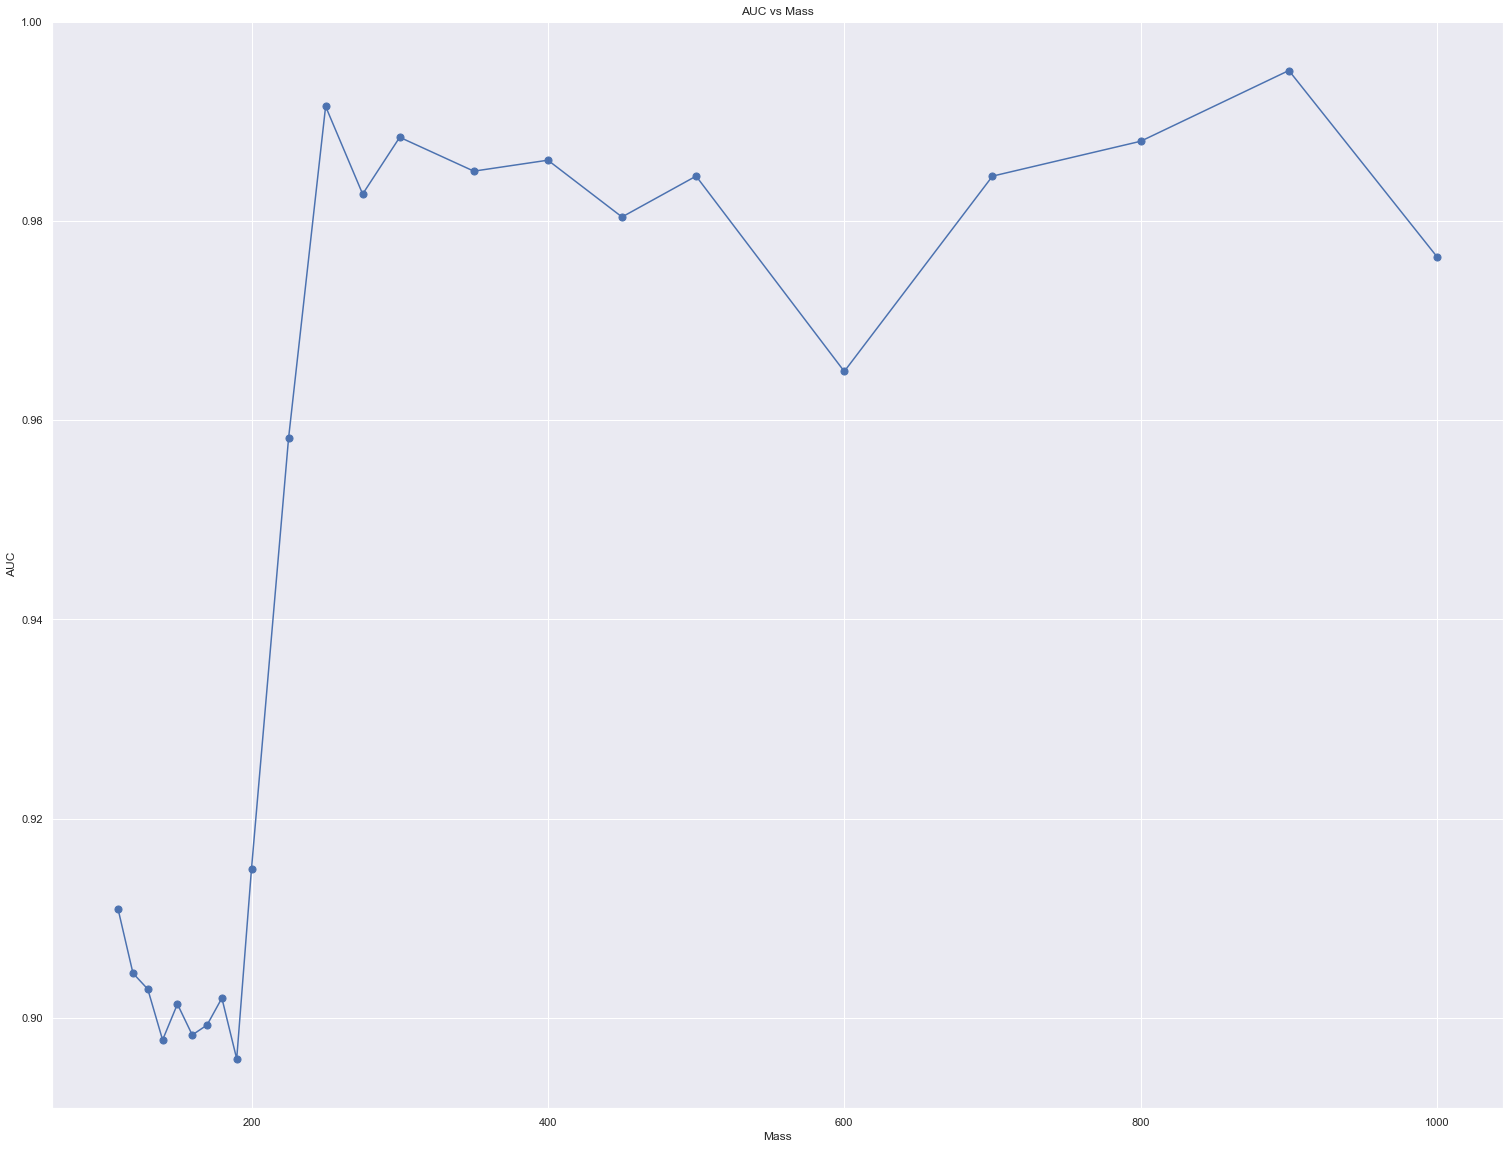

[0.9109,
 0.9045,
 0.9029,
 0.8978,
 0.9014,
 0.8983,
 0.8993,
 0.902,
 0.8959,
 0.915,
 0.9582,
 0.9915,
 0.9827,
 0.9884,
 0.985,
 0.9861,
 0.9804,
 0.9845,
 0.9649,
 0.9845,
 0.988,
 0.9951,
 0.9764]

In [124]:
# test on *all* signal mass
auc_vs_mass(model, data, auc_index=2, mass_intervals=sig_intervals, verbose=0)

* Background mass

In [77]:
all_bkg_mass = data.background['mA'].round()
all_bkg_mass = sorted(all_bkg_mass.unique())

bkg_mass = np.linspace(min(all_bkg_mass), max(all_bkg_mass), 20)

bkg_intervals = np.stack(
    [bkg_mass - 10, bkg_mass + 10], axis=-1)

bkg_intervals, bkg_mass

(array([[ 100.        ,  120.        ],
        [ 146.84210526,  166.84210526],
        [ 193.68421053,  213.68421053],
        [ 240.52631579,  260.52631579],
        [ 287.36842105,  307.36842105],
        [ 334.21052632,  354.21052632],
        [ 381.05263158,  401.05263158],
        [ 427.89473684,  447.89473684],
        [ 474.73684211,  494.73684211],
        [ 521.57894737,  541.57894737],
        [ 568.42105263,  588.42105263],
        [ 615.26315789,  635.26315789],
        [ 662.10526316,  682.10526316],
        [ 708.94736842,  728.94736842],
        [ 755.78947368,  775.78947368],
        [ 802.63157895,  822.63157895],
        [ 849.47368421,  869.47368421],
        [ 896.31578947,  916.31578947],
        [ 943.15789474,  963.15789474],
        [ 990.        , 1010.        ]]),
 array([ 110.        ,  156.84210526,  203.68421053,  250.52631579,
         297.36842105,  344.21052632,  391.05263158,  437.89473684,
         484.73684211,  531.57894737,  578.42105263,  625.2631

Mass: [100. 120.] -> 110.0
Mass: [146.84 166.84] -> 156.84
Mass: [193.68 213.68] -> 203.68
Mass: [240.53 260.53] -> 250.53
Mass: [287.37 307.37] -> 297.37
Mass: [334.21 354.21] -> 344.21
Mass: [381.05 401.05] -> 391.05
Mass: [427.89 447.89] -> 437.89
Mass: [474.74 494.74] -> 484.74
Mass: [521.58 541.58] -> 531.58
Mass: [568.42 588.42] -> 578.42
Mass: [615.26 635.26] -> 625.26
Mass: [662.11 682.11] -> 672.11
Mass: [708.95 728.95] -> 718.95
Mass: [755.79 775.79] -> 765.79
Mass: [802.63 822.63] -> 812.63
Mass: [849.47 869.47] -> 859.47
Mass: [896.32 916.32] -> 906.32
Mass: [943.16 963.16] -> 953.16
Mass: [ 990. 1010.] -> 1000.0


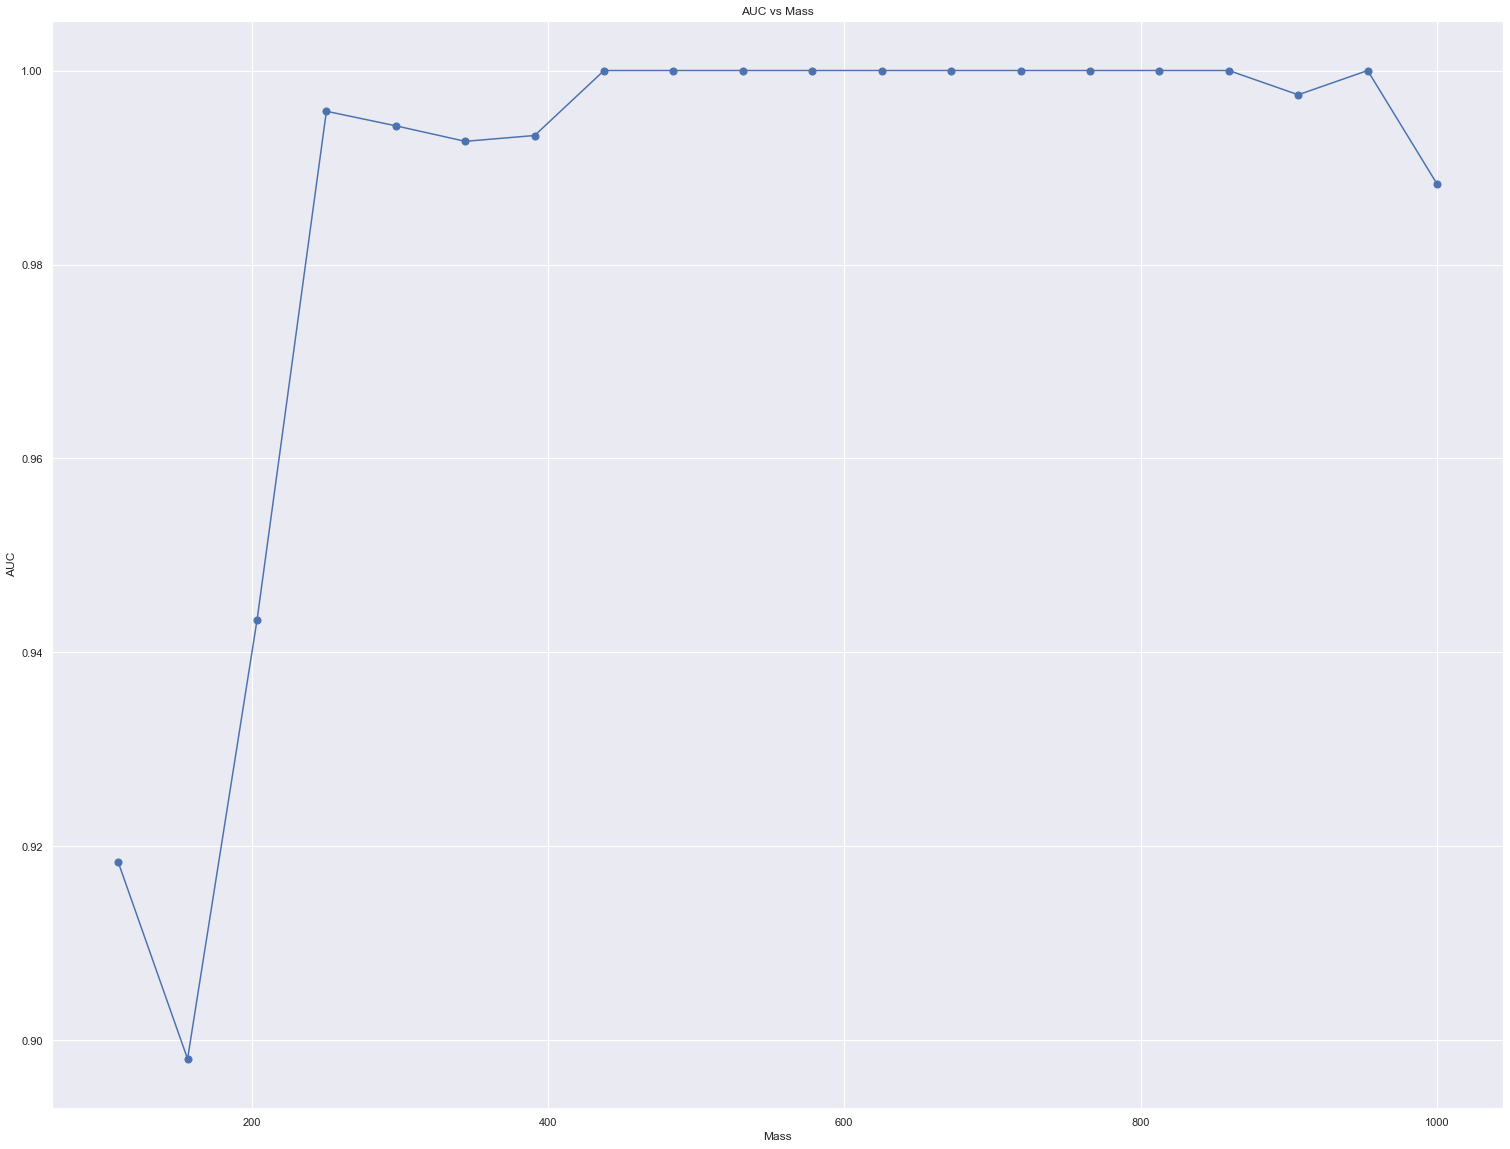

[0.9184,
 0.8981,
 0.9433,
 0.9958,
 0.9943,
 0.9927,
 0.9933,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9975,
 1.0,
 0.9883]

In [98]:
# test on *binned* background mass
auc_vs_mass(model, data, auc_index=2, mass_intervals=bkg_intervals, verbose=0)

* Fake mass

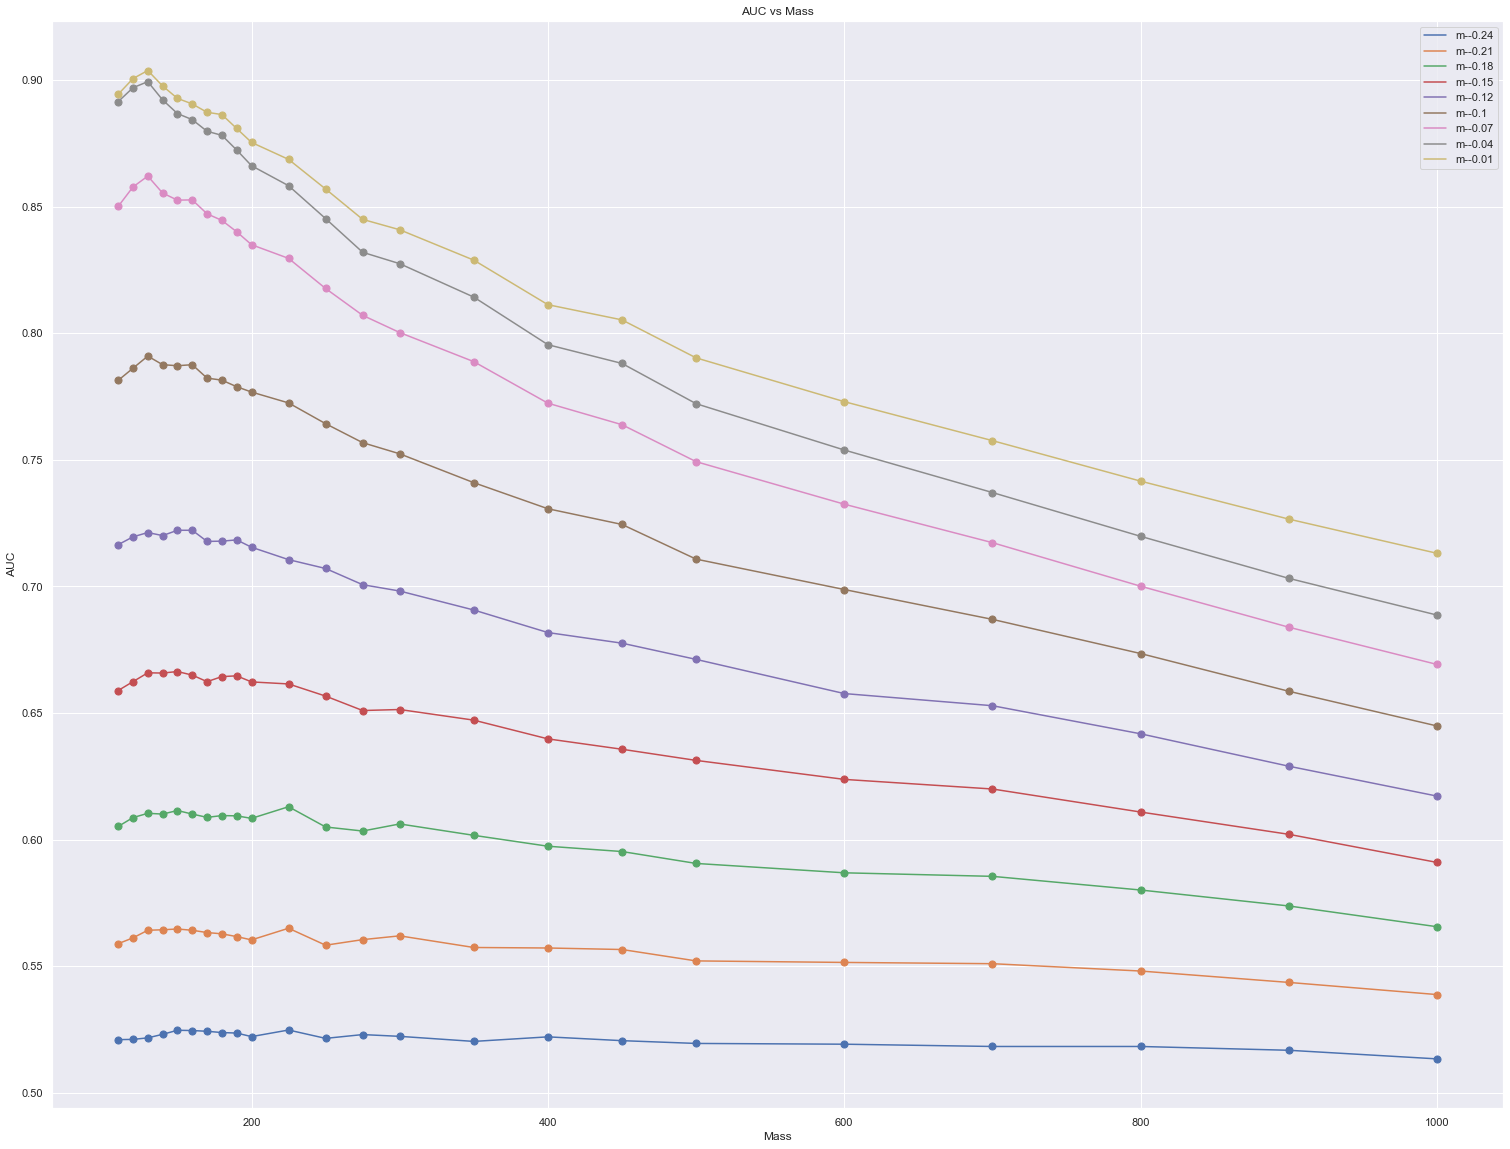

{-0.23595505766570568: [0.521,
  0.5211,
  0.5217,
  0.5231,
  0.5247,
  0.5246,
  0.5243,
  0.5238,
  0.5236,
  0.5222,
  0.5248,
  0.5215,
  0.523,
  0.5223,
  0.5203,
  0.5221,
  0.5206,
  0.5195,
  0.5192,
  0.5183,
  0.5183,
  0.5168,
  0.5134],
 -0.20786516973748803: [0.5589,
  0.5612,
  0.5642,
  0.5644,
  0.5647,
  0.5642,
  0.5633,
  0.5628,
  0.5617,
  0.5604,
  0.565,
  0.5583,
  0.5605,
  0.562,
  0.5574,
  0.5572,
  0.5566,
  0.5521,
  0.5515,
  0.551,
  0.5481,
  0.5436,
  0.5388],
 -0.17977528180927038: [0.6052,
  0.6087,
  0.6104,
  0.6101,
  0.6115,
  0.6101,
  0.6088,
  0.6095,
  0.6094,
  0.6084,
  0.613,
  0.605,
  0.6034,
  0.6062,
  0.6017,
  0.5974,
  0.5953,
  0.5906,
  0.5869,
  0.5855,
  0.5801,
  0.5738,
  0.5656],
 -0.15168539388105273: [0.6589,
  0.6624,
  0.6659,
  0.6658,
  0.6664,
  0.665,
  0.6624,
  0.6644,
  0.6647,
  0.6623,
  0.6615,
  0.6567,
  0.651,
  0.6514,
  0.6472,
  0.6398,
  0.6357,
  0.6313,
  0.6238,
  0.62,
  0.6109,
  0.6021,
  0.591],


In [105]:
fake_mass = np.linspace(-100, 100, 9)
fake_mass = data.m_scaler.transform(np.reshape(fake_mass, newshape=(-1, 1)))
fake_mass = np.squeeze(fake_mass)

auc_vs_no_mass(model, data, auc_index=2, mass_intervals=sig_intervals, const=fake_mass, verbose=0)

* How much the PNN relies on the features `x`?

Set some (or all) of them to zero and compute the AUC w.r.t. the mass.

In [15]:
def auc_vs_mass_no_features(model, dataset, auc_index: int, mass_intervals: Union[np.ndarray, List[tuple]], 
                            figsize=(26, 20), features={}, verbose=1):
    assert_2d_array(mass_intervals)
    plt.figure(figsize=figsize)

    mass = mean_mass(mass_intervals)
    auc = {k: [] for k in features.keys()}
    
    for label, indexes in features.items():
        print(f'Features: {label}, {indexes}')
        
        for interval in mass_intervals:
            x, y = dataset.get_by_mass(interval)
        
            # mask features
            for i in indexes:
                zero_feature = np.zeros_like(x['x'][:, i])
                x['x'][:, i] = zero_feature
        
            print(f'Mass: {np.round(interval, 2)} -> {round(np.mean(interval), 2)}')
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=verbose)
            
            auc_score = round(score[auc_index], 4)
            auc[label].append(check_underflow(auc_score, score[1]))
            
    plt.title(f'AUC vs Mass')
    
    for label in features.keys():
        plt.plot(mass, auc[label])
        plt.scatter(mass, auc[label], s=50, label=label)
    
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.legend()
    plt.show()
    return auc

Features: all, []
Mass: [100. 120.] -> 110.0
Mass: [110. 130.] -> 120.0
Mass: [120. 140.] -> 130.0
Mass: [130. 150.] -> 140.0
Mass: [140. 160.] -> 150.0
Mass: [150. 170.] -> 160.0
Mass: [160. 180.] -> 170.0
Mass: [170. 190.] -> 180.0
Mass: [180. 200.] -> 190.0
Mass: [190. 210.] -> 200.0
Mass: [215. 235.] -> 225.0
Mass: [240. 260.] -> 250.0
Mass: [265. 285.] -> 275.0
Mass: [290. 310.] -> 300.0
Mass: [340. 360.] -> 350.0
Mass: [390. 410.] -> 400.0
Mass: [440. 460.] -> 450.0
Mass: [490. 510.] -> 500.0
Mass: [590. 610.] -> 600.0
Mass: [690. 710.] -> 700.0
Mass: [790. 810.] -> 800.0
Mass: [890. 910.] -> 900.0
Mass: [ 990. 1010.] -> 1000.0
Features: none, [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Mass: [100. 120.] -> 110.0
Mass: [110. 130.] -> 120.0
Mass: [120. 140.] -> 130.0
Mass: [130. 150.] -> 140.0
Mass: [140. 160.] -> 150.0
Mass: [150. 170.] -> 160.0
Mass: [160. 180.] -> 170.0
Mass: [170. 190.] -> 180.0
Mass: [180. 200.] -> 190.0
Mass: [190. 210.] -> 200.0
Mass: [215. 235.] -> 225.0
Mass

Mass: [440. 460.] -> 450.0
Mass: [490. 510.] -> 500.0
Mass: [590. 610.] -> 600.0
Mass: [690. 710.] -> 700.0
Mass: [790. 810.] -> 800.0
Mass: [890. 910.] -> 900.0
Mass: [ 990. 1010.] -> 1000.0
Features: no-11, [11]
Mass: [100. 120.] -> 110.0
Mass: [110. 130.] -> 120.0
Mass: [120. 140.] -> 130.0
Mass: [130. 150.] -> 140.0
Mass: [140. 160.] -> 150.0
Mass: [150. 170.] -> 160.0
Mass: [160. 180.] -> 170.0
Mass: [170. 190.] -> 180.0
Mass: [180. 200.] -> 190.0
Mass: [190. 210.] -> 200.0
Mass: [215. 235.] -> 225.0
Mass: [240. 260.] -> 250.0
Mass: [265. 285.] -> 275.0
Mass: [290. 310.] -> 300.0
Mass: [340. 360.] -> 350.0
Mass: [390. 410.] -> 400.0
Mass: [440. 460.] -> 450.0
Mass: [490. 510.] -> 500.0
Mass: [590. 610.] -> 600.0
Mass: [690. 710.] -> 700.0
Mass: [790. 810.] -> 800.0
Mass: [890. 910.] -> 900.0
Mass: [ 990. 1010.] -> 1000.0
Features: no-12, [12]
Mass: [100. 120.] -> 110.0
Mass: [110. 130.] -> 120.0
Mass: [120. 140.] -> 130.0
Mass: [130. 150.] -> 140.0
Mass: [140. 160.] -> 150.0
Mass:

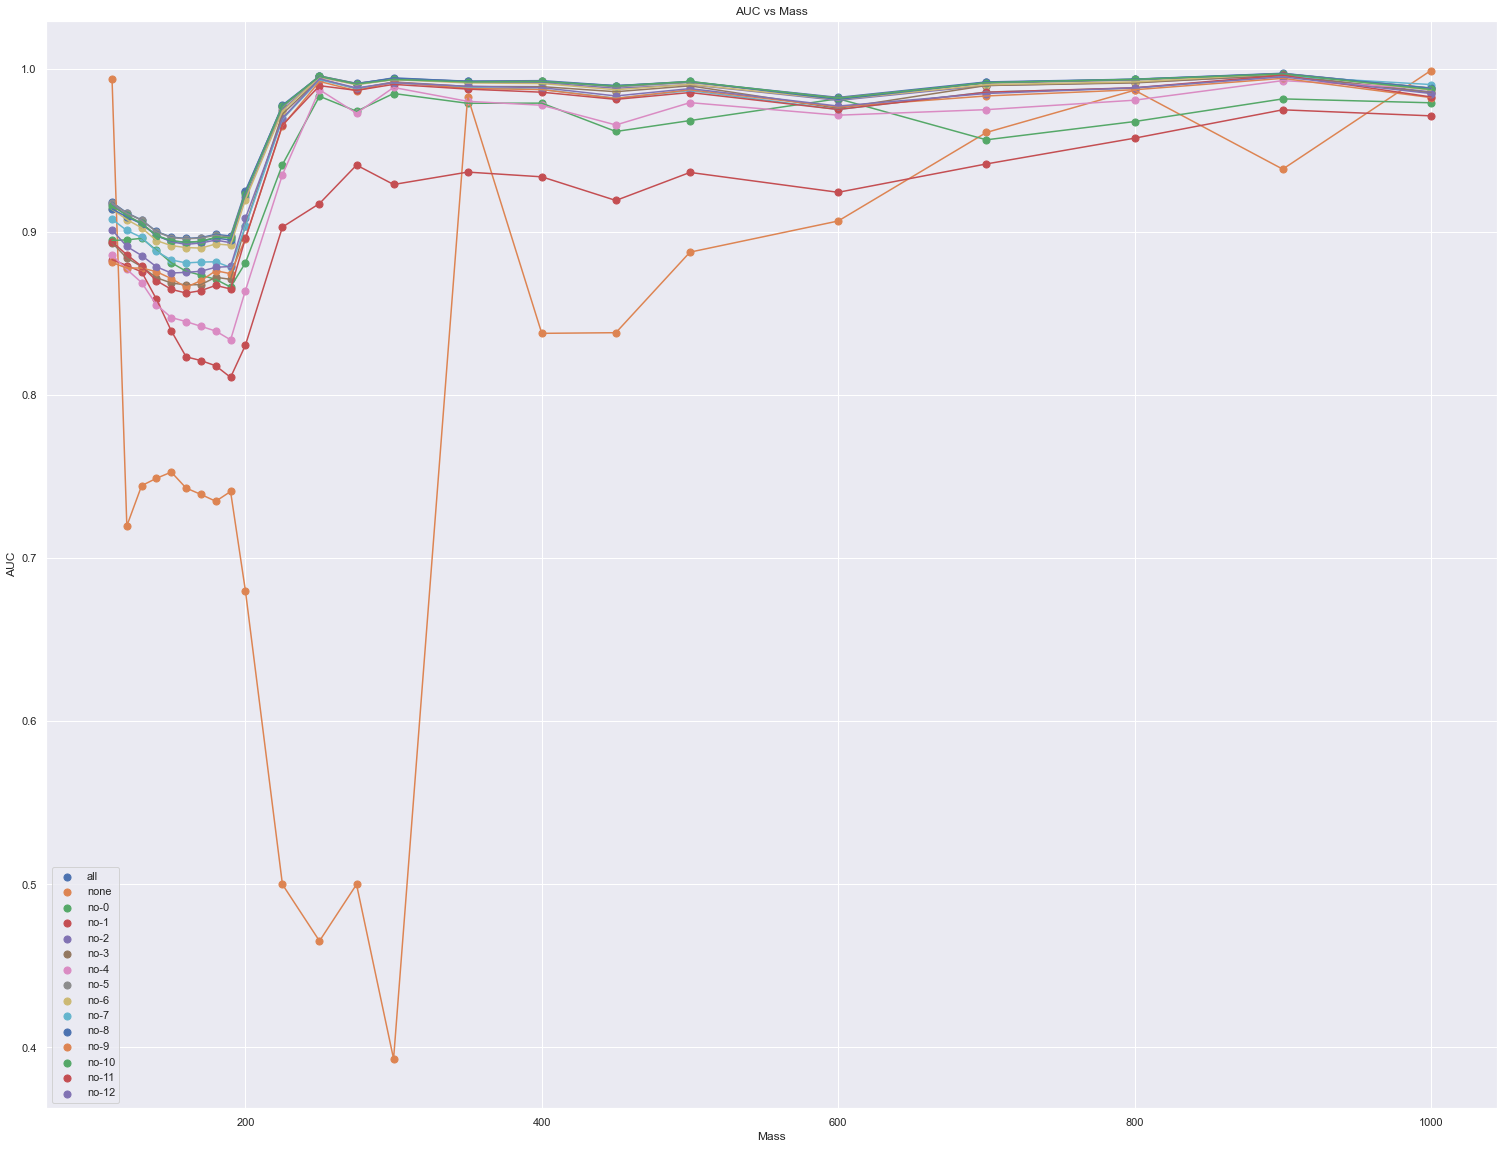

{'all': [0.9184,
  0.9119,
  0.9075,
  0.9005,
  0.897,
  0.8962,
  0.8967,
  0.8987,
  0.8977,
  0.9254,
  0.9774,
  0.9958,
  0.9913,
  0.9943,
  0.9927,
  0.993,
  0.9899,
  0.9922,
  0.9827,
  0.9922,
  0.9939,
  0.9975,
  0.9883],
 'none': [0.9943,
  0.7199,
  0.7446,
  0.7491,
  0.7529,
  0.7431,
  0.7392,
  0.735,
  0.741,
  0.6802,
  0.5,
  0.4653,
  0.5,
  0.393,
  0.9832,
  0.838,
  0.8384,
  0.8878,
  0.9069,
  0.9612,
  0.9871,
  0.9387,
  0.9992],
 'no-0': [0.895,
  0.8953,
  0.8963,
  0.889,
  0.8813,
  0.8761,
  0.8737,
  0.8711,
  0.8664,
  0.8812,
  0.9415,
  0.9834,
  0.9742,
  0.9851,
  0.9791,
  0.9792,
  0.9618,
  0.9685,
  0.9819,
  0.9567,
  0.9679,
  0.9818,
  0.9794],
 'no-1': [0.8832,
  0.8796,
  0.8757,
  0.8589,
  0.8395,
  0.8236,
  0.8213,
  0.8181,
  0.811,
  0.8307,
  0.9032,
  0.9176,
  0.9412,
  0.9293,
  0.9369,
  0.934,
  0.9195,
  0.9367,
  0.9245,
  0.9419,
  0.9577,
  0.9751,
  0.9714],
 'no-2': [0.9175,
  0.9103,
  0.9053,
  0.8981,
  0.8941,
  0

In [103]:
features = {
    'all': [],
    'none': np.arange(0, 13),
}

# add an entry telling to drop only the i-th feature column
for i in range(13):
    features[f'no-{i}'] = [i]

auc_vs_mass_no_features(model, data, auc_index=2, mass_intervals=sig_intervals, features=features, verbose=0)

* AUC with error bars

In [16]:
def split_dataset(dataset: Dataset, data: tuple, num_folds=10, seed=SEED):
    """Splits a given Dataframe into k disjoint folds"""
    fold_size = data[1].shape[0] // num_folds
    folds = []
    
    # first, construct a dataframe from data, where `data = dict(x, m), y`
    df = pd.concat([
        pd.DataFrame(data[0]['x'], columns=dataset.columns['feature']),
        pd.DataFrame(data[0]['m'], columns=['mass']),
        pd.DataFrame(data[1], columns=['label'])
    ], axis=1)
    
    for _ in range(num_folds - 1):
        fold = df.sample(fold_size, random_state=seed)
        folds.append(fold)
        
        df.drop(fold.index, inplace=True)
    
    folds.append(df)
    
    # make each `fold` be structured like `data`, i.e. fold = tuple(dict(x, m), y)
    for i, fold in enumerate(folds):       
        fold_x = dict(x=fold[dataset.columns['feature']].values, 
                      m=fold['mass'].values)
        fold_y = fold['label'].values
    
        folds[i] = (fold_x, fold_y)
    
    return folds

In [17]:
def auc_with_error(model, dataset, auc_index: int, mass_intervals: Union[np.ndarray, List[tuple]], 
                   figsize=(26, 20), num_folds=10, verbose=0):
    assert_2d_array(mass_intervals)
    plt.figure(figsize=figsize)

    mass = mean_mass(mass_intervals)
    auc = {fold: [] for fold in range(num_folds)}
    
    for interval in mass_intervals:
        x, y = dataset.get_by_mass(interval)
        
        folds = split_dataset(dataset, data=(x, y), num_folds=num_folds)
        
        for i, fold in enumerate(folds):
            score = model.evaluate(x=fold[0], y=fold[1], batch_size=128, verbose=verbose)

            auc_score = round(score[auc_index], 4)
            auc[i].append(check_underflow(auc_score, score[1]))
        
        print(f'Mass:{np.round(interval, 2)} -> {round(np.mean(interval))}')
    
    # compute average AUC (over folds)
    avg_auc = []
    
    for i, _ in enumerate(mass):
        score = 0.0
        
        for fold in range(num_folds):
            score += auc[fold][i]
        
        avg_auc.append(round(score / num_folds, 4))
    
    plt.title(f'AUC vs Mass')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.plot(mass, avg_auc, label='avg')
    plt.scatter(mass, avg_auc, s=50, color='b')
    
    for i in range(num_folds):
        plt.scatter(mass, auc[i], s=30, color='r')
    
    plt.show()
    return auc

Mass:[100. 120.] -> 110.0
Mass:[110. 130.] -> 120.0
Mass:[120. 140.] -> 130.0
Mass:[130. 150.] -> 140.0
Mass:[140. 160.] -> 150.0
Mass:[150. 170.] -> 160.0
Mass:[160. 180.] -> 170.0
Mass:[170. 190.] -> 180.0
Mass:[180. 200.] -> 190.0
Mass:[190. 210.] -> 200.0
Mass:[215. 235.] -> 225.0
Mass:[240. 260.] -> 250.0
Mass:[265. 285.] -> 275.0
Mass:[290. 310.] -> 300.0
Mass:[340. 360.] -> 350.0
Mass:[390. 410.] -> 400.0
Mass:[440. 460.] -> 450.0
Mass:[490. 510.] -> 500.0
Mass:[590. 610.] -> 600.0
Mass:[690. 710.] -> 700.0
Mass:[790. 810.] -> 800.0
Mass:[890. 910.] -> 900.0
Mass:[ 990. 1010.] -> 1000.0


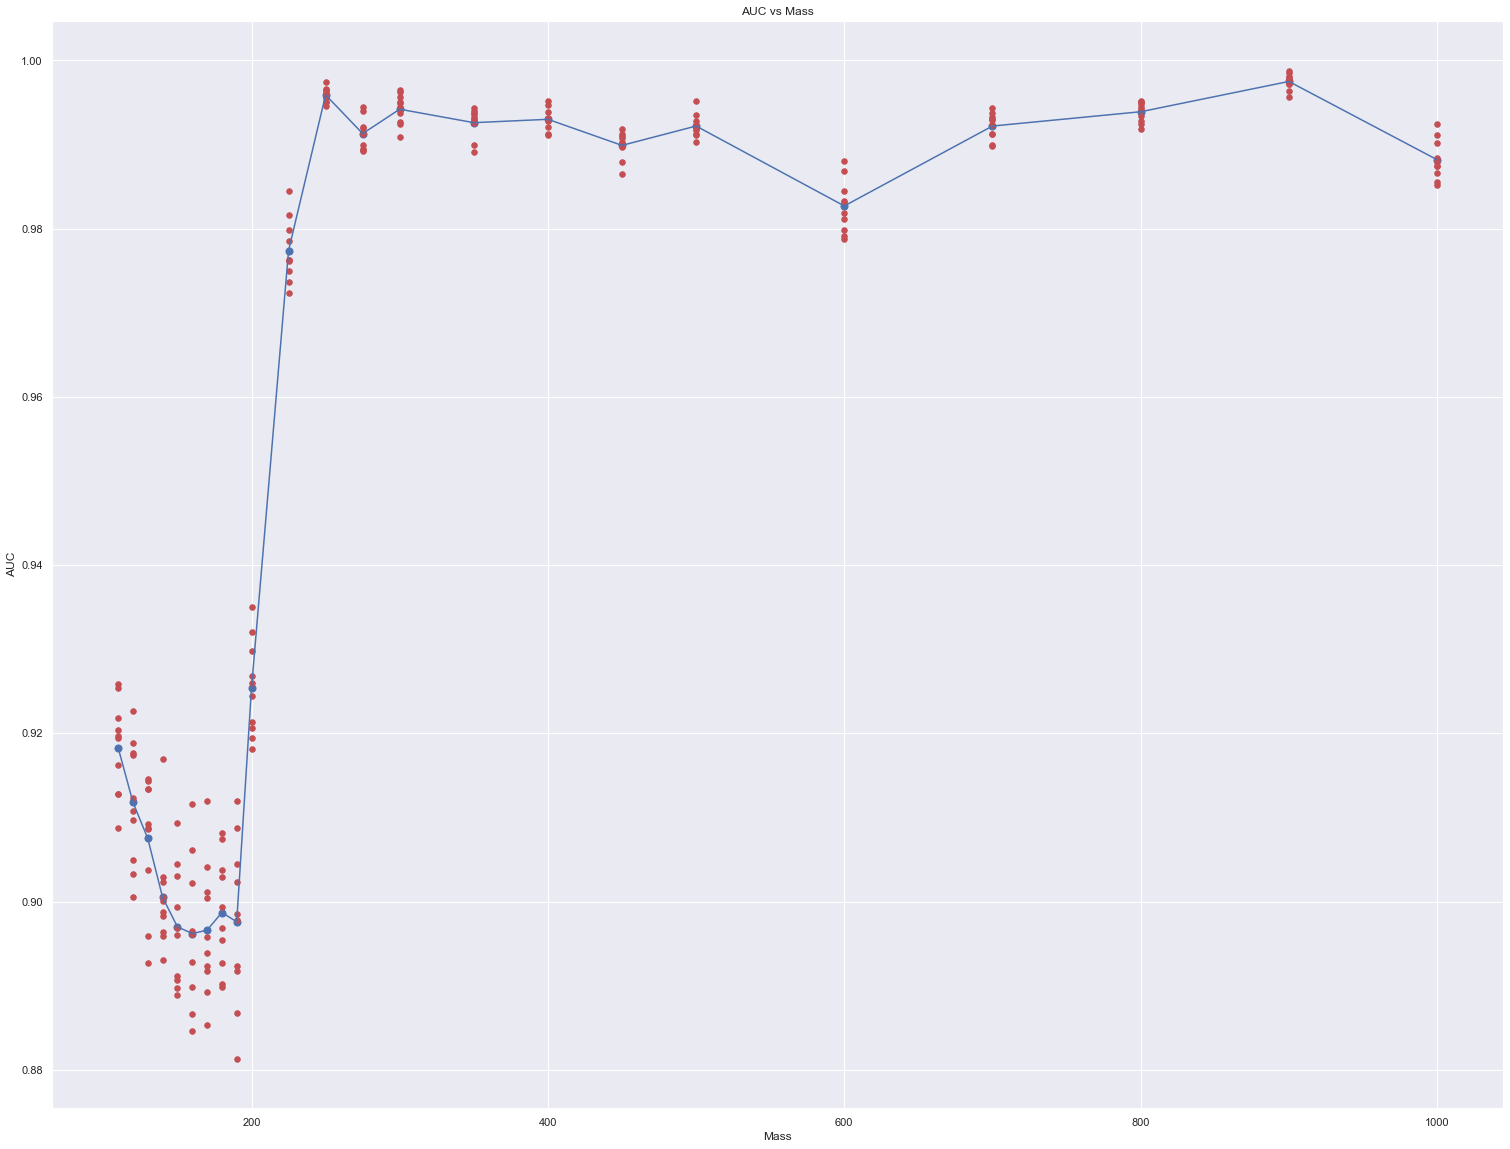

{0: [0.9087,
  0.9227,
  0.9037,
  0.893,
  0.896,
  0.8866,
  0.8917,
  0.8969,
  0.8978,
  0.9244,
  0.9816,
  0.9965,
  0.9945,
  0.9927,
  0.9943,
  0.9952,
  0.991,
  0.9903,
  0.9845,
  0.9933,
  0.9942,
  0.9985,
  0.9884],
 1: [0.9128,
  0.9189,
  0.8959,
  0.8983,
  0.8889,
  0.9116,
  0.9011,
  0.8994,
  0.8813,
  0.9206,
  0.9845,
  0.995,
  0.9893,
  0.9956,
  0.9938,
  0.9939,
  0.9908,
  0.9913,
  0.9811,
  0.9923,
  0.9918,
  0.998,
  0.9902],
 2: [0.9259,
  0.9049,
  0.9146,
  0.9006,
  0.8897,
  0.8928,
  0.912,
  0.9029,
  0.9087,
  0.9181,
  0.9763,
  0.9959,
  0.994,
  0.9951,
  0.9891,
  0.9921,
  0.9865,
  0.9935,
  0.9881,
  0.99,
  0.9945,
  0.9964,
  0.9911],
 3: [0.9162,
  0.9006,
  0.9087,
  0.8964,
  0.8969,
  0.8961,
  0.8924,
  0.8899,
  0.8918,
  0.9213,
  0.9798,
  0.9946,
  0.9913,
  0.9962,
  0.993,
  0.9911,
  0.9897,
  0.9923,
  0.9869,
  0.993,
  0.9928,
  0.9988,
  0.9852],
 4: [0.9204,
  0.9033,
  0.9134,
  0.8988,
  0.9094,
  0.8846,
  0.9004,
  

In [114]:
auc_with_error(model, data, auc_index=2, mass_intervals=sig_intervals, num_folds=10, verbose=0)

* Generalization by interpolation

In [31]:
all_mass = np.arange(100, 1100, 100)
train_mass = np.arange(100, 1000, 200)
test_mass = np.arange(200, 1100, 200)

print('train-mass:', train_mass)
print('test-mass:', test_mass)

train-mass: [100 300 500 700 900]
test-mass: [ 200  400  600  800 1000]


In [18]:
non_sig_intervals

[(105, 115),
 (115, 125),
 (125, 135),
 (135, 145),
 (145, 155),
 (155, 165),
 (165, 175),
 (175, 185),
 (185, 195),
 (195, 205),
 (205, 212.5),
 (212.5, 237.5),
 (237.5, 262.5),
 (262.5, 289.5),
 (289.5, 325),
 (325, 375),
 (375, 425),
 (425, 475),
 (475, 550),
 (550, 650),
 (650, 750),
 (750, 850),
 (850, 950),
 (950, 1000)]

In [19]:
# intervals = np.asarray(
#       [[ 105.,  115.],
#        [ 125.,  135.],
#        [ 145.,  155.],
#        [ 165.,  175.],
#        [ 185.,  195.],
#        [ 220.,  230.],
#        [ 270.,  280.],
#        [ 345.,  355.],
#        [ 445.,  455.],
#        [ 595.,  605.],
#        [ 795.,  805.],
#        [ 995., 1005.]])

intervals = [
    (105, 115),
    (125, 135),
    (145, 155),
    (165, 175),
    (185, 195),
    (205, 212.5),
    (237.5, 262.5),
    (289.5, 325),
    (375, 425),
    (475, 550),
    (650, 750),
    (850, 950)]

intervals

[(105, 115),
 (125, 135),
 (145, 155),
 (165, 175),
 (185, 195),
 (205, 212.5),
 (237.5, 262.5),
 (289.5, 325),
 (375, 425),
 (475, 550),
 (650, 750),
 (850, 950)]

In [ ]:
[ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
        200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
        600.,  700.,  800.,  900., 1000.]

In [25]:
# train_mass = [110, 130, 150,  170,  190]
# test_mass = [120, 140, 160, 180, 200]

train_mass = [200, 250, 300]
test_mass = [225, 275]

In [20]:
train_data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
train_data.load(mass_intervals=intervals)

len(train_data.ds)

[signal] loading...
[background] loading...
dataset loaded.


2218435

In [21]:
train_x, train_y = train_data.get()

In [ ]:
model_gen = AffinePNN(input_shapes=dict(m=(1,), x=(data.train_features.shape[-1],)), 
                      units=[300, 150, 100, 50])

decay_steps = int(train_y.shape[0] / batch_size * (1.0 - val_split))
lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75+0.25)

model_gen.compile(optimizer_class=opt.Adam, epsilon=0.0003125,
                  metrics=['binary_accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall()],
                  lr=lr_schedule)

_ = model_gen.fit(x=train_x, y=train_y, batch_size=batch_size,
                 validation_split=val_split, epochs=10)  # look for overfitting

In [ ]:
model_gen.load_weights('my_weights/interpolation/weights')

In [38]:
model_gen.save_weights('my_weights/interpolation/weights')

Mass:[105 115] -> 110.0
Mass:[115 125] -> 120.0
Mass:[125 135] -> 130.0
Mass:[135 145] -> 140.0
Mass:[145 155] -> 150.0
Mass:[155 165] -> 160.0
Mass:[165 175] -> 170.0
Mass:[175 185] -> 180.0
Mass:[185 195] -> 190.0
Mass:[195 205] -> 200.0
Mass:[205.  212.5] -> 209.0
Mass:[212.5 237.5] -> 225.0
Mass:[237.5 262.5] -> 250.0
Mass:[262.5 289.5] -> 276.0
Mass:[289.5 325. ] -> 307.0
Mass:[325 375] -> 350.0
Mass:[375 425] -> 400.0
Mass:[425 475] -> 450.0
Mass:[475 550] -> 512.0
Mass:[550 650] -> 600.0
Mass:[650 750] -> 700.0
Mass:[750 850] -> 800.0
Mass:[850 950] -> 900.0
Mass:[ 950 1000] -> 975.0


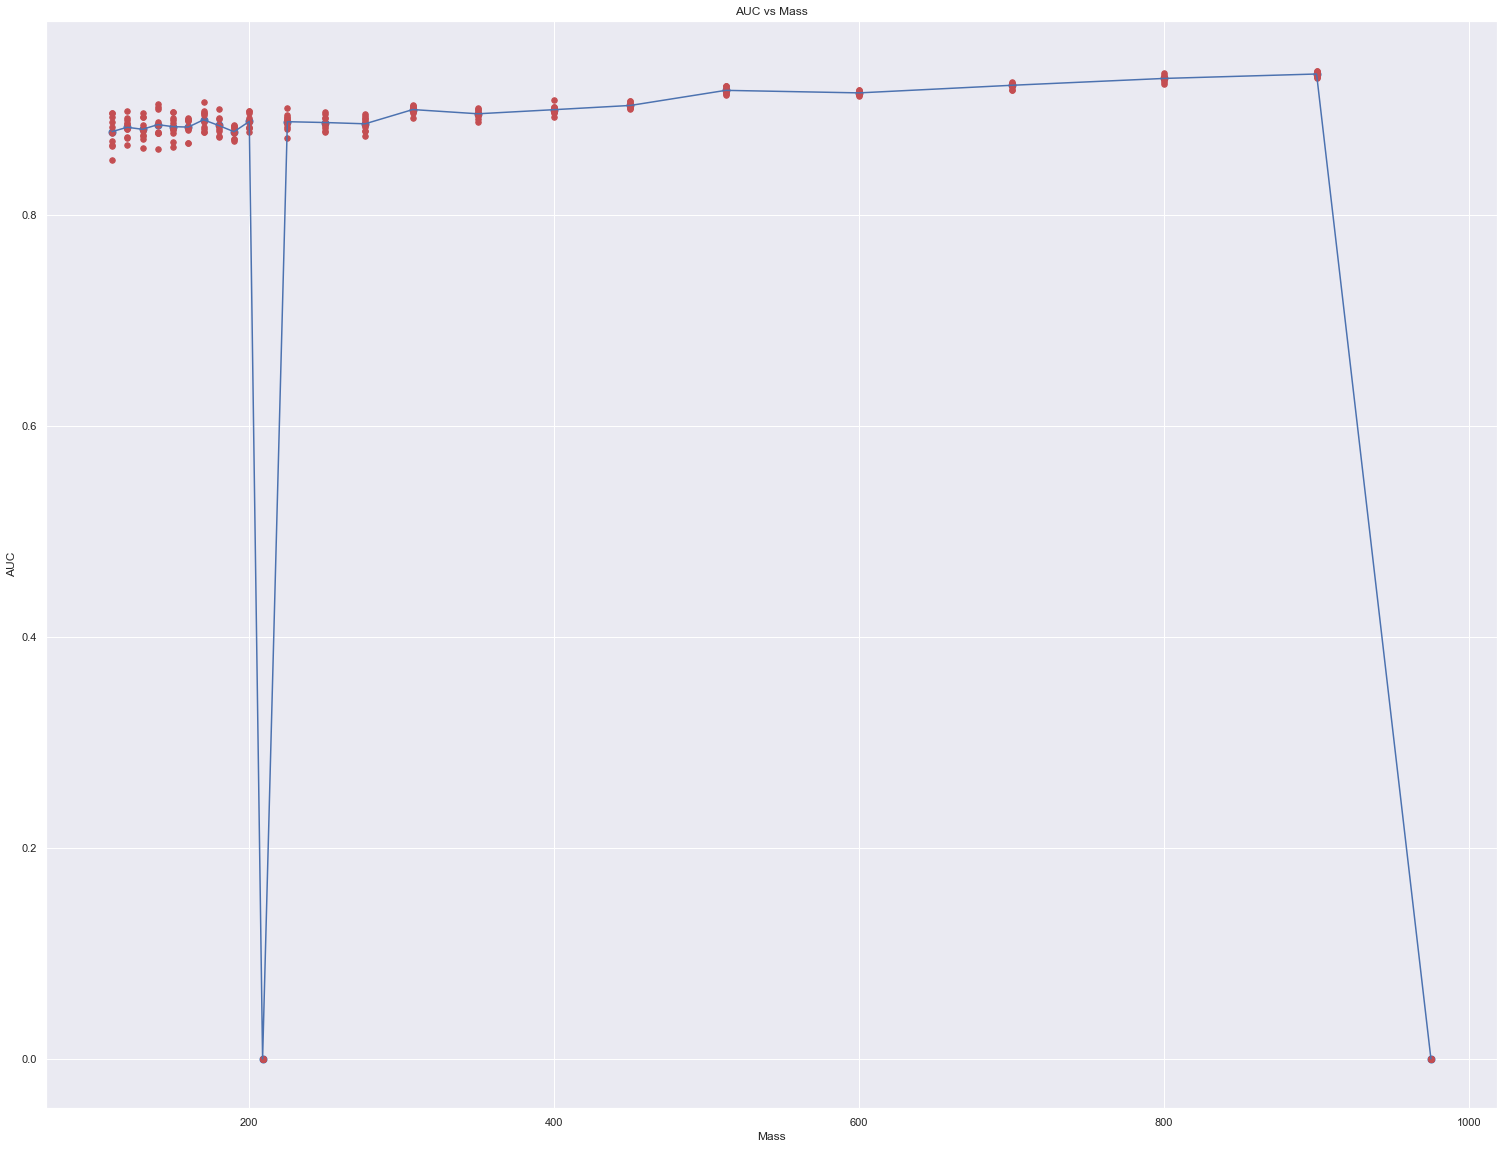

{0: [0.8515,
  0.886,
  0.8922,
  0.8773,
  0.8896,
  0.8894,
  0.8785,
  0.874,
  0.8844,
  0.8879,
  0.0,
  0.8913,
  0.8822,
  0.8955,
  0.9037,
  0.8883,
  0.8973,
  0.9077,
  0.9174,
  0.914,
  0.9187,
  0.9345,
  0.9305,
  0.0],
 1: [0.8969,
  0.8984,
  0.8637,
  0.8882,
  0.887,
  0.8917,
  0.8962,
  0.8906,
  0.8716,
  0.8913,
  0.0,
  0.8902,
  0.8784,
  0.8794,
  0.9012,
  0.8933,
  0.8929,
  0.8998,
  0.9153,
  0.9165,
  0.9185,
  0.9254,
  0.9362,
  0.0],
 2: [0.8881,
  0.8733,
  0.8745,
  0.9023,
  0.8817,
  0.8815,
  0.8982,
  0.8798,
  0.8847,
  0.8818,
  0.0,
  0.9008,
  0.8872,
  0.8907,
  0.9034,
  0.8962,
  0.9023,
  0.9076,
  0.9141,
  0.9125,
  0.9234,
  0.9322,
  0.9337,
  0.0],
 3: [0.8649,
  0.8916,
  0.8925,
  0.8625,
  0.8971,
  0.8906,
  0.9064,
  0.8809,
  0.8696,
  0.8875,
  0.0,
  0.8944,
  0.8914,
  0.8886,
  0.8984,
  0.8948,
  0.8978,
  0.902,
  0.9162,
  0.9187,
  0.9242,
  0.9306,
  0.9318,
  0.0],
 4: [0.8699,
  0.8873,
  0.8721,
  0.9047,
  0.864,
 

In [23]:
auc_with_error(model_gen, data, auc_index=2, mass_intervals=non_sig_intervals, num_folds=10)

Mass:[105 115] -> 110.0
Mass:[115 125] -> 120.0
Mass:[125 135] -> 130.0
Mass:[135 145] -> 140.0
Mass:[145 155] -> 150.0
Mass:[155 165] -> 160.0
Mass:[165 175] -> 170.0
Mass:[175 185] -> 180.0
Mass:[185 195] -> 190.0
Mass:[195 205] -> 200.0
Mass:[205.  212.5] -> 209.0
Mass:[212.5 237.5] -> 225.0
Mass:[237.5 262.5] -> 250.0
Mass:[262.5 289.5] -> 276.0
Mass:[289.5 325. ] -> 307.0
Mass:[325 375] -> 350.0
Mass:[375 425] -> 400.0
Mass:[425 475] -> 450.0
Mass:[475 550] -> 512.0
Mass:[550 650] -> 600.0
Mass:[650 750] -> 700.0
Mass:[750 850] -> 800.0
Mass:[850 950] -> 900.0
Mass:[ 950 1000] -> 975.0


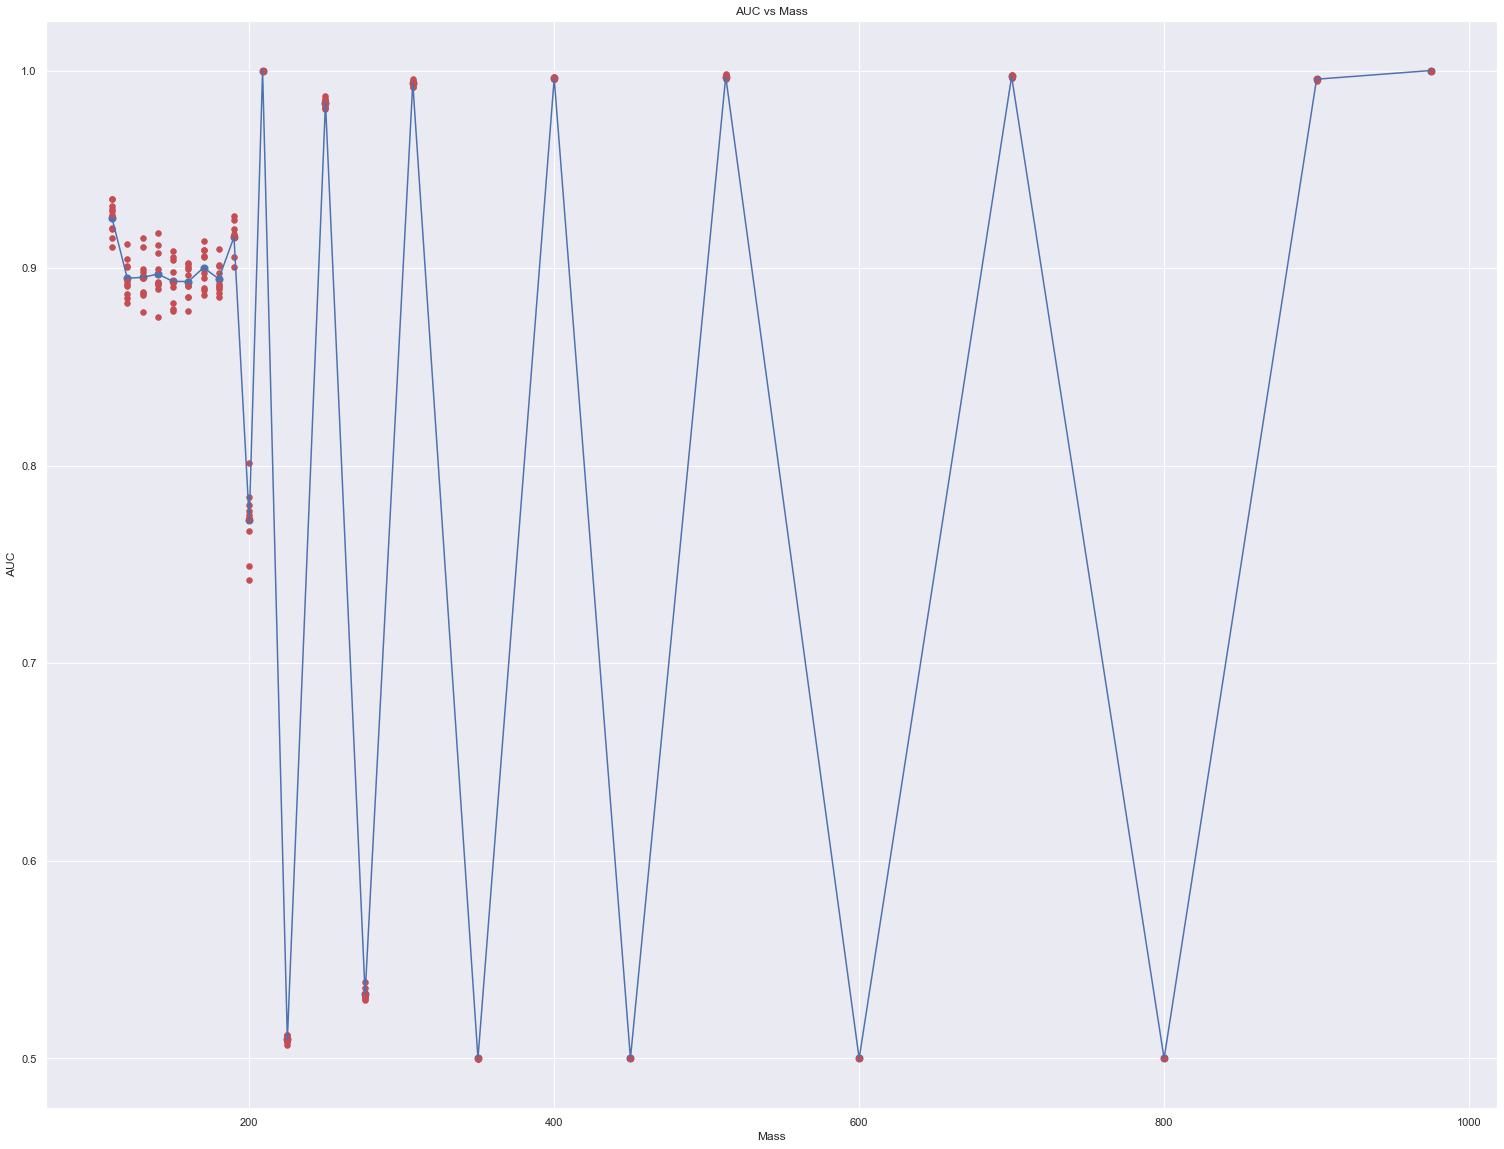

{0: [0.9106,
  0.8936,
  0.8994,
  0.8923,
  0.8979,
  0.9006,
  0.8863,
  0.8872,
  0.92,
  0.8016,
  1.0,
  0.5092,
  0.9842,
  0.5325,
  0.9947,
  0.5,
  0.9956,
  0.5,
  0.997,
  0.5,
  0.9967,
  0.5,
  0.9949,
  1.0],
 1: [0.935,
  0.912,
  0.8777,
  0.8997,
  0.9039,
  0.9027,
  0.9094,
  0.9013,
  0.9006,
  0.7799,
  1.0,
  0.5099,
  0.9846,
  0.5359,
  0.9934,
  0.5,
  0.9963,
  0.5,
  0.9961,
  0.5,
  0.997,
  0.5,
  0.9957,
  1.0],
 2: [0.9291,
  0.8847,
  0.8873,
  0.9116,
  0.8927,
  0.8911,
  0.9093,
  0.8896,
  0.9263,
  0.7841,
  1.0,
  0.5114,
  0.9851,
  0.531,
  0.993,
  0.5,
  0.996,
  0.5,
  0.9975,
  0.5,
  0.9975,
  0.5,
  0.9959,
  1.0],
 3: [0.915,
  0.9004,
  0.9107,
  0.8755,
  0.9086,
  0.9019,
  0.9137,
  0.8904,
  0.9157,
  0.7753,
  1.0,
  0.512,
  0.9818,
  0.5322,
  0.9918,
  0.5,
  0.9961,
  0.5,
  0.9967,
  0.5,
  0.9972,
  0.5,
  0.9952,
  1.0],
 4: [0.9196,
  0.9048,
  0.8881,
  0.9178,
  0.8781,
  0.8853,
  0.9057,
  0.9014,
  0.9159,
  0.7671,
  1.

In [33]:
# evaluate on "test masses"
auc_with_error(model_gen, data, auc_index=2, mass_intervals=non_sig_intervals, num_folds=10)

Mass:[100. 120.] -> 110.0
Mass:[110. 130.] -> 120.0
Mass:[120. 140.] -> 130.0
Mass:[130. 150.] -> 140.0
Mass:[140. 160.] -> 150.0
Mass:[150. 170.] -> 160.0
Mass:[160. 180.] -> 170.0
Mass:[170. 190.] -> 180.0
Mass:[180. 200.] -> 190.0
Mass:[190. 225.] -> 208.0
Mass:[200. 250.] -> 225.0
Mass:[225. 275.] -> 250.0
Mass:[250. 300.] -> 275.0
Mass:[275. 350.] -> 312.0
Mass:[300. 400.] -> 350.0
Mass:[350. 450.] -> 400.0
Mass:[400. 500.] -> 450.0
Mass:[450. 600.] -> 525.0
Mass:[500. 700.] -> 600.0
Mass:[600. 800.] -> 700.0
Mass:[700. 900.] -> 800.0
Mass:[ 800. 1000.] -> 900.0


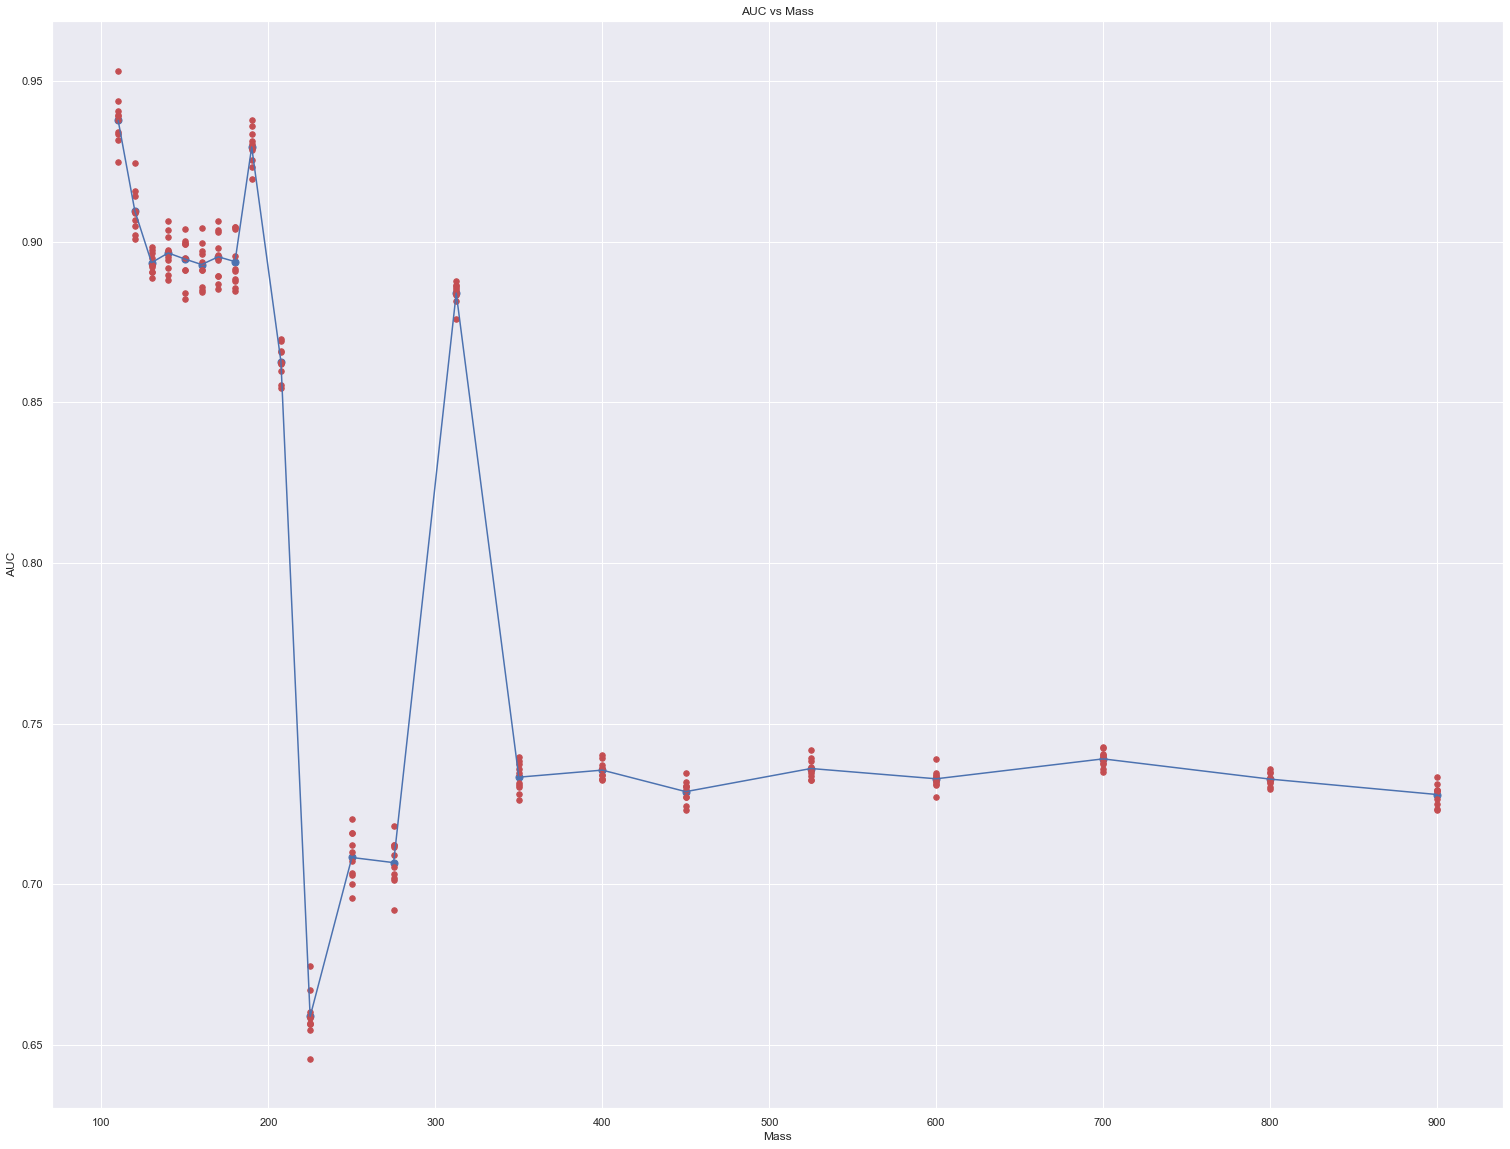

{0: [0.9394,
  0.9022,
  0.8973,
  0.8973,
  0.8992,
  0.885,
  0.9038,
  0.8916,
  0.9361,
  0.862,
  0.6568,
  0.7123,
  0.7122,
  0.8839,
  0.728,
  0.7372,
  0.723,
  0.7357,
  0.7338,
  0.736,
  0.7318,
  0.7293],
 1: [0.9248,
  0.9048,
  0.8921,
  0.8953,
  0.9002,
  0.8996,
  0.8959,
  0.8857,
  0.9379,
  0.8622,
  0.6586,
  0.7029,
  0.7052,
  0.8834,
  0.7301,
  0.7328,
  0.7243,
  0.7366,
  0.731,
  0.7428,
  0.7296,
  0.7334],
 2: [0.9406,
  0.9244,
  0.8888,
  0.8895,
  0.8994,
  0.8937,
  0.8944,
  0.904,
  0.9194,
  0.8691,
  0.6583,
  0.6999,
  0.7031,
  0.8857,
  0.7382,
  0.7325,
  0.7304,
  0.7324,
  0.734,
  0.7376,
  0.7314,
  0.729],
 3: [0.9318,
  0.9008,
  0.8949,
  0.9038,
  0.8841,
  0.8859,
  0.8892,
  0.9045,
  0.9232,
  0.8624,
  0.6602,
  0.7158,
  0.7091,
  0.8865,
  0.7395,
  0.7401,
  0.7318,
  0.7324,
  0.7346,
  0.7386,
  0.7325,
  0.7265],
 4: [0.9438,
  0.9157,
  0.8928,
  0.897,
  0.8948,
  0.8963,
  0.9066,
  0.8847,
  0.9292,
  0.8656,
  0.6564,
 

In [34]:
# evaluate on "test masses"
auc_with_error(model_gen, data, auc_index=2, mass_intervals=overlap_sig_intervals, num_folds=10)

Mass:[105. 115.] -> 110.0
Mass:[115. 125.] -> 120.0
Mass:[125. 135.] -> 130.0
Mass:[135. 145.] -> 140.0
Mass:[145. 155.] -> 150.0
Mass:[155. 165.] -> 160.0
Mass:[165. 175.] -> 170.0
Mass:[175. 185.] -> 180.0
Mass:[185. 195.] -> 190.0
Mass:[195. 205.] -> 200.0
Mass:[220. 230.] -> 225.0
Mass:[245. 255.] -> 250.0
Mass:[270. 280.] -> 275.0
Mass:[295. 305.] -> 300.0
Mass:[345. 355.] -> 350.0
Mass:[395. 405.] -> 400.0
Mass:[445. 455.] -> 450.0
Mass:[495. 505.] -> 500.0
Mass:[595. 605.] -> 600.0
Mass:[695. 705.] -> 700.0
Mass:[795. 805.] -> 800.0
Mass:[895. 905.] -> 900.0
Mass:[ 995. 1005.] -> 1000.0


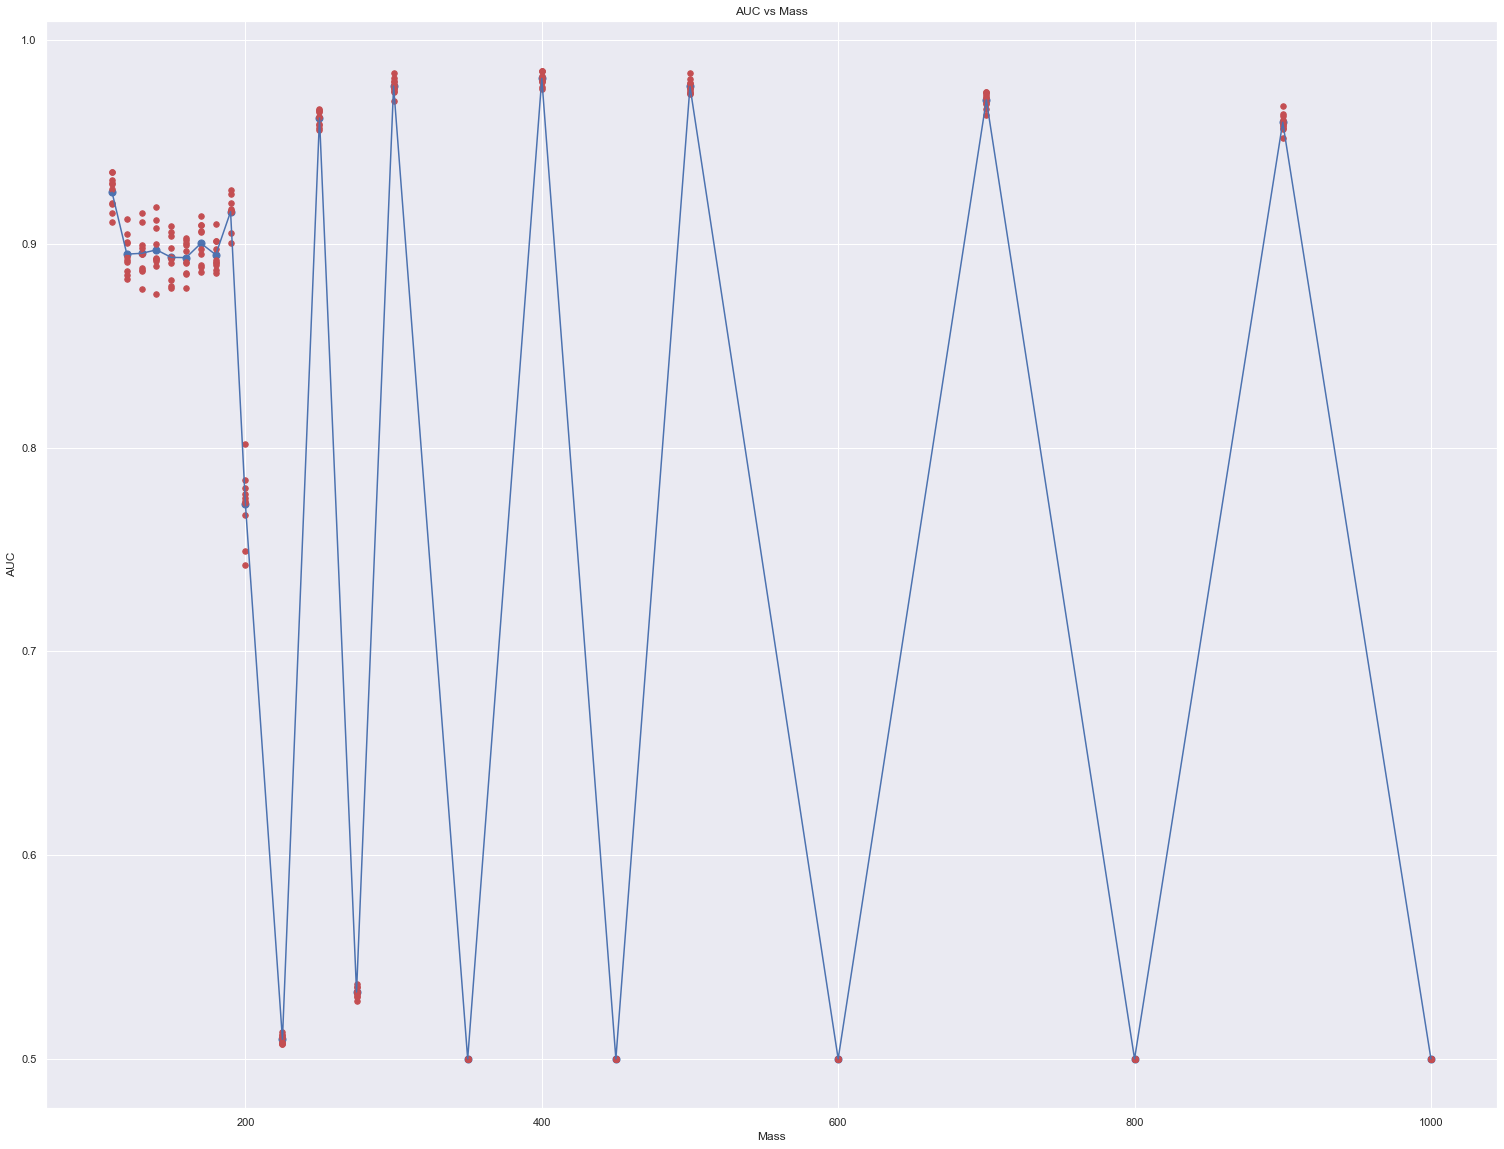

{0: [0.9106,
  0.8936,
  0.8994,
  0.8923,
  0.8979,
  0.9006,
  0.8863,
  0.8872,
  0.92,
  0.8016,
  0.5117,
  0.9621,
  0.5365,
  0.9781,
  0.5,
  0.9814,
  0.5,
  0.9839,
  0.5,
  0.9732,
  0.5,
  0.9569,
  0.5],
 1: [0.935,
  0.912,
  0.8777,
  0.8997,
  0.9039,
  0.9027,
  0.9094,
  0.9013,
  0.9006,
  0.7799,
  0.5132,
  0.9646,
  0.5286,
  0.9839,
  0.5,
  0.9848,
  0.5,
  0.9741,
  0.5,
  0.966,
  0.5,
  0.9593,
  0.5],
 2: [0.9291,
  0.8847,
  0.8873,
  0.9116,
  0.8927,
  0.8911,
  0.9093,
  0.8896,
  0.9263,
  0.7841,
  0.5106,
  0.959,
  0.5335,
  0.9799,
  0.5,
  0.98,
  0.5,
  0.979,
  0.5,
  0.9714,
  0.5,
  0.9562,
  0.5],
 3: [0.915,
  0.9004,
  0.9107,
  0.8755,
  0.9086,
  0.9019,
  0.9137,
  0.8904,
  0.9157,
  0.7753,
  0.5103,
  0.9569,
  0.5351,
  0.9702,
  0.5,
  0.9796,
  0.5,
  0.9761,
  0.5,
  0.9634,
  0.5,
  0.9579,
  0.5],
 4: [0.9196,
  0.9048,
  0.8881,
  0.9178,
  0.8781,
  0.8853,
  0.9057,
  0.9014,
  0.9159,
  0.7671,
  0.5075,
  0.9663,
  0.5319,
 

In [35]:
# evaluate on "all masses"
auc_with_error(model_gen, data, auc_index=2, mass_intervals=sig_intervals, num_folds=10)

## Explore Data
* Plot each input feature (distinguish between *signal* and *background*)
* Find out correlations between *mass* and the features
---

In [105]:
# a sample of the dataset
df = data.ds
df.sample(25)

,mA,dimuon_deltar,dimuon_deltaphi,dimuon_deltaeta,dimuon_M,met_pt,met_phi,met_eta,bjet_n,bjet_1_pt,...,ljet_n,ljet_1_pt,ljet_1_eta,deltar_bjet1_dimuon,deltapt_bjet1_dimuon,deltaeta_bjet1_dimuon,deltaphi_bjet1_dimuon,PU_Weight,weight,type
1408315,384.670227,4.046986,2.731689,2.985962,243.084976,23.144300,2.552734,0.0,0.0,73.812500,...,0.0,51.843750,-0.747925,0.000000,0.000000,0.000000,0.000000,1.125935,1.000000,0.0
1273368,250.670364,3.562294,2.729492,2.289062,144.584396,101.586388,-0.450989,0.0,0.0,128.750000,...,3.0,50.312500,0.477783,0.000000,0.000000,0.000000,0.000000,0.992675,1.000000,0.0
212094,200.000000,3.074126,2.947675,0.872620,196.133270,33.130215,-0.712891,0.0,1.0,28.968750,...,0.0,20.781250,0.384399,3.054115,8.564294,1.290247,2.768190,0.998296,2.186612,1.0
1820576,808.445129,3.122065,2.146466,2.267151,142.469498,100.010307,1.407959,0.0,1.0,114.937500,...,2.0,79.562500,-1.796387,2.187080,57.923920,1.241279,1.800708,1.073452,1.000000,0.0
574502,645.587769,3.131184,2.959747,1.021866,124.209908,67.626747,-2.242188,0.0,0.0,51.718750,...,0.0,29.609375,-0.648071,0.000000,0.000000,0.000000,0.000000,1.120658,1.000000,0.0
1890823,887.474548,2.713633,1.448730,2.294556,183.328262,96.825478,-0.542847,0.0,2.0,43.281250,...,2.0,115.125000,0.943237,0.736863,47.873302,0.329077,0.659299,1.091130,1.000000,0.0
720477,400.000000,1.910801,0.164734,1.903687,124.697037,20.504135,-1.376221,0.0,0.0,83.312500,...,0.0,25.671875,-0.014107,0.000000,0.000000,0.000000,0.000000,0.965139,0.542467,1.0
1028218,500.000000,3.413077,3.114118,1.396912,515.917969,70.976639,0.041389,0.0,1.0,41.406250,...,1.0,31.703125,2.292480,4.795286,1.783327,4.090475,2.502554,1.018162,0.553207,1.0
894499,450.000000,3.085387,3.085327,0.019287,454.544495,29.051786,3.013672,0.0,0.0,31.515625,...,1.0,46.843750,1.575928,0.000000,0.000000,0.000000,0.000000,0.982873,0.535598,1.0
2335836,592.042725,2.371877,1.943298,1.359924,146.938782,60.289013,3.047852,0.0,1.0,79.750000,...,1.0,21.578125,1.009766,2.553526,4.731050,0.422165,2.518387,1.036924,1.000000,0.0


In [25]:
def histogram(col: str, bins=None):
    plt.title(col)
    plt.hist(data.background[col], bins=bins, alpha=0.3, label='bkg', color='red')
    plt.hist(data.signal[col], bins=bins, alpha=0.7, label='sig', color='blue')
    plt.legend()

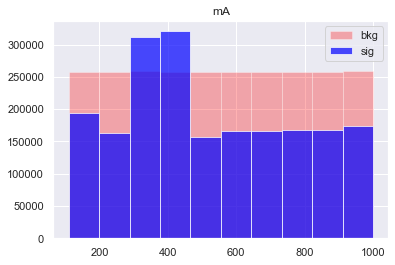

In [26]:
# bkg vs singla mass distribution
histogram(col='mA')

In [63]:
columns = data.train_features.columns
columns

Index(['dimuon_deltar', 'dimuon_deltaphi', 'dimuon_deltaeta', 'met_pt',
       'deltar_bjet1_dimuon', 'deltapt_bjet1_dimuon', 'deltaeta_bjet1_dimuon',
       'bjet_1_pt', 'bjet_1_eta', 'ljet_1_pt', 'ljet_1_eta', 'bjet_n',
       'ljet_n'],
      dtype='object')

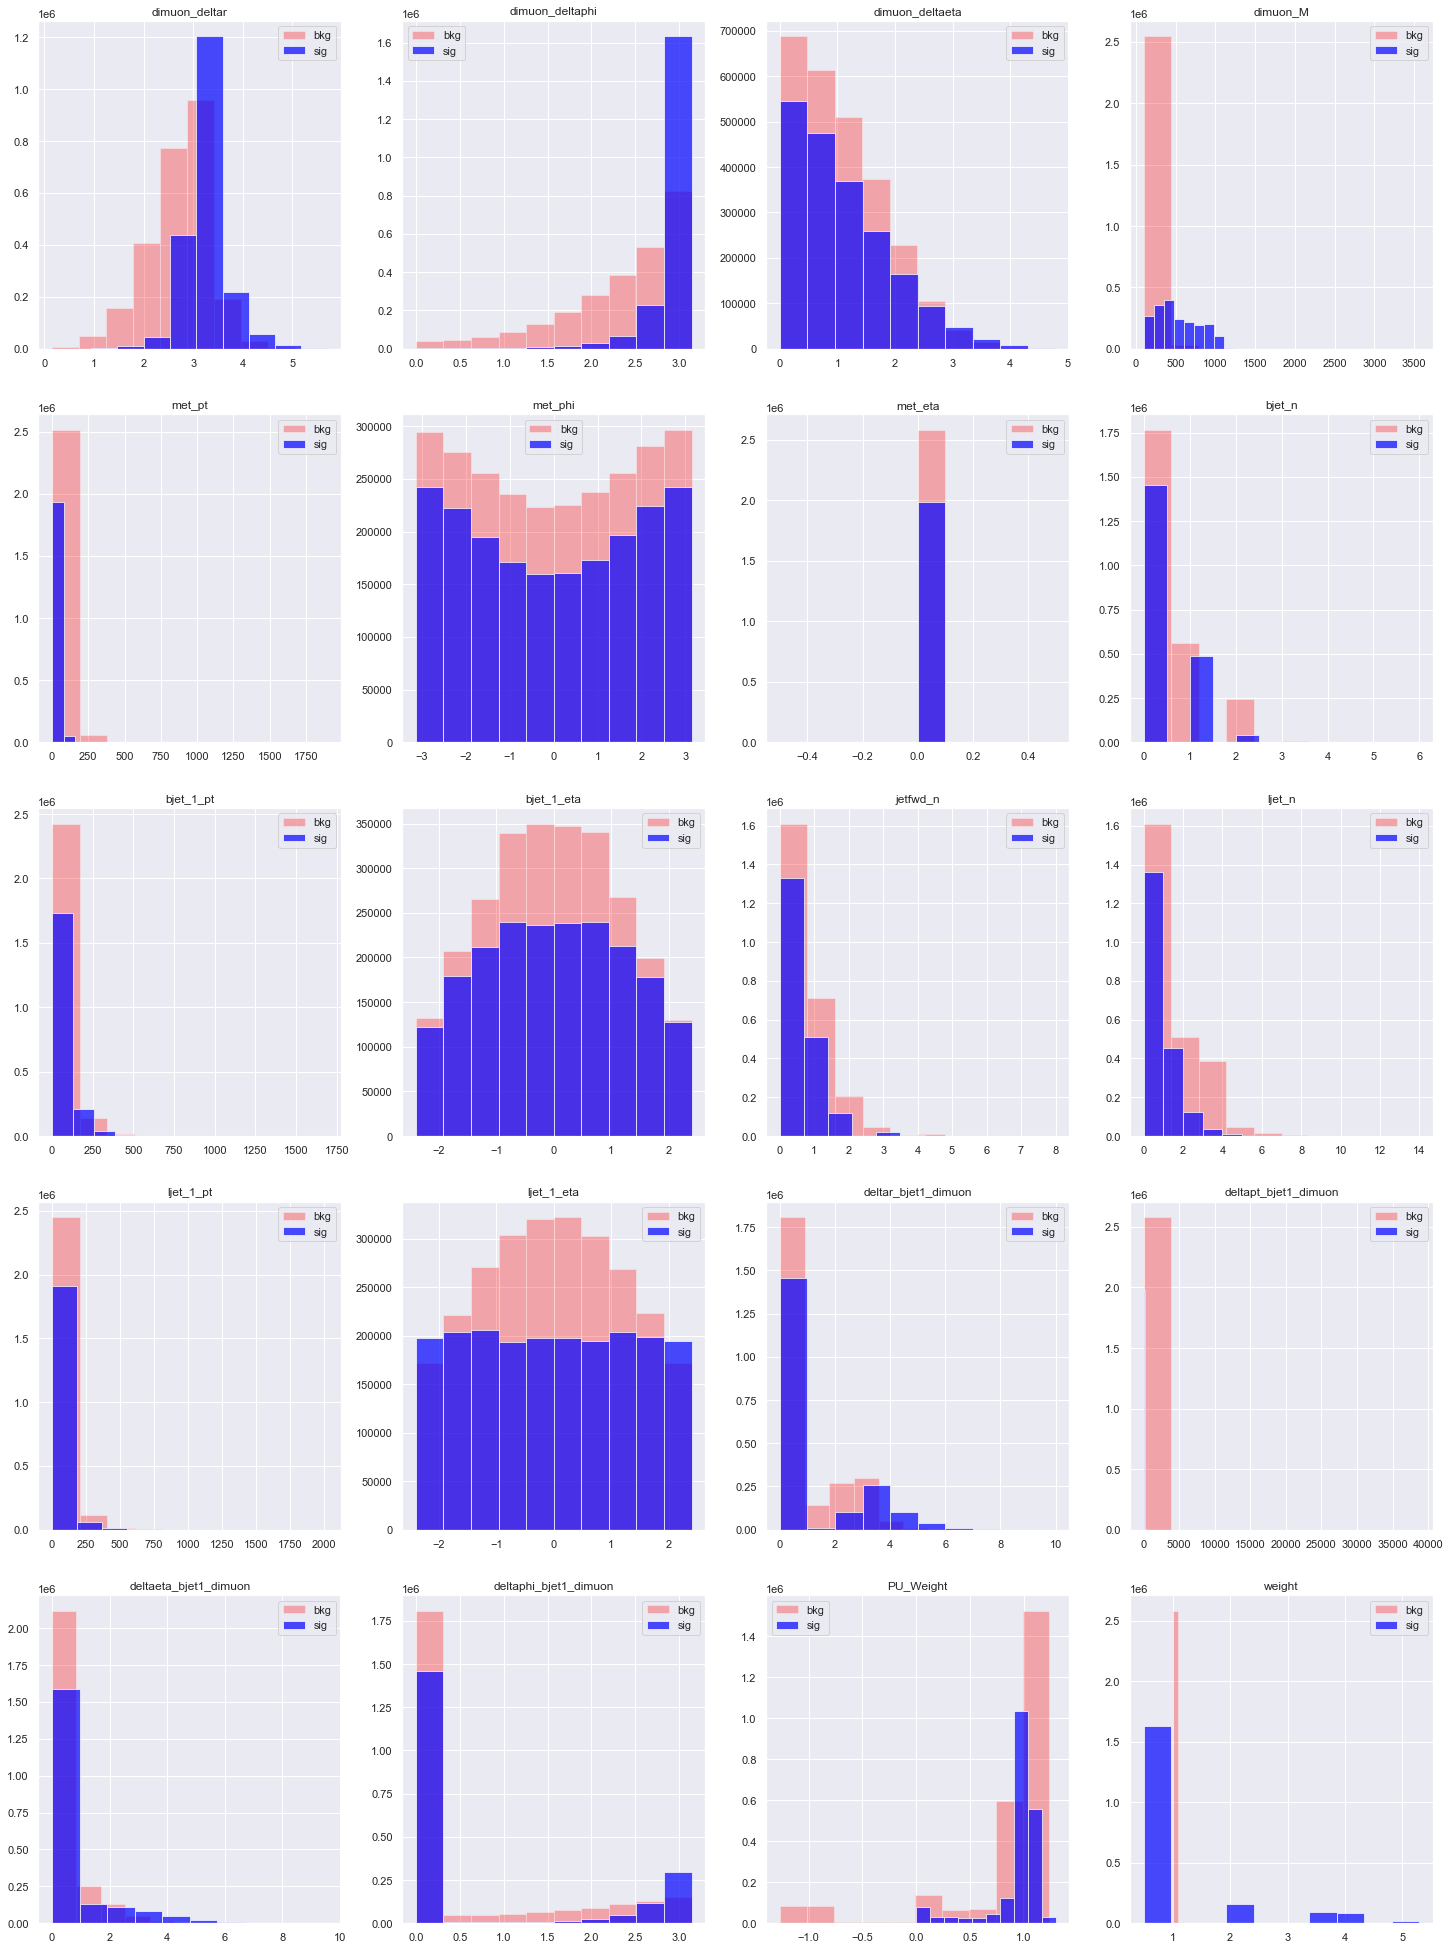

In [131]:
# compare feature distribution
plt.figure(figsize=(25, 35))

for i, col in enumerate(columns):
    plt.subplot(5, 4, i + 1)
    histogram(col)

In [161]:
def scatter(col: str, limit=10_000, seed=SEED):
    mass_bkg = data.background['mA'].sample(limit, random_state=seed)
    col_bkg = data.background[col].sample(limit, random_state=seed)
    
    mass_sig = data.signal['mA'].sample(limit, random_state=seed)
    col_sig = data.signal[col].sample(limit, random_state=seed)
    
    plt.title(f'mA vs {col}')
    plt.scatter(mass_bkg, col_bkg, alpha=0.3, label='bkg', color='red', marker='o', s=10)
    plt.scatter(mass_sig, col_sig, alpha=0.7, label='sig', color='blue', marker='s', s=40)
    
    plt.xlabel('mA')
    plt.ylabel(col)
    plt.legend()

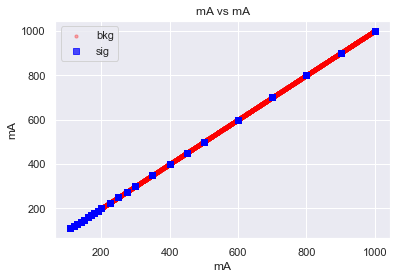

In [162]:
scatter('mA')

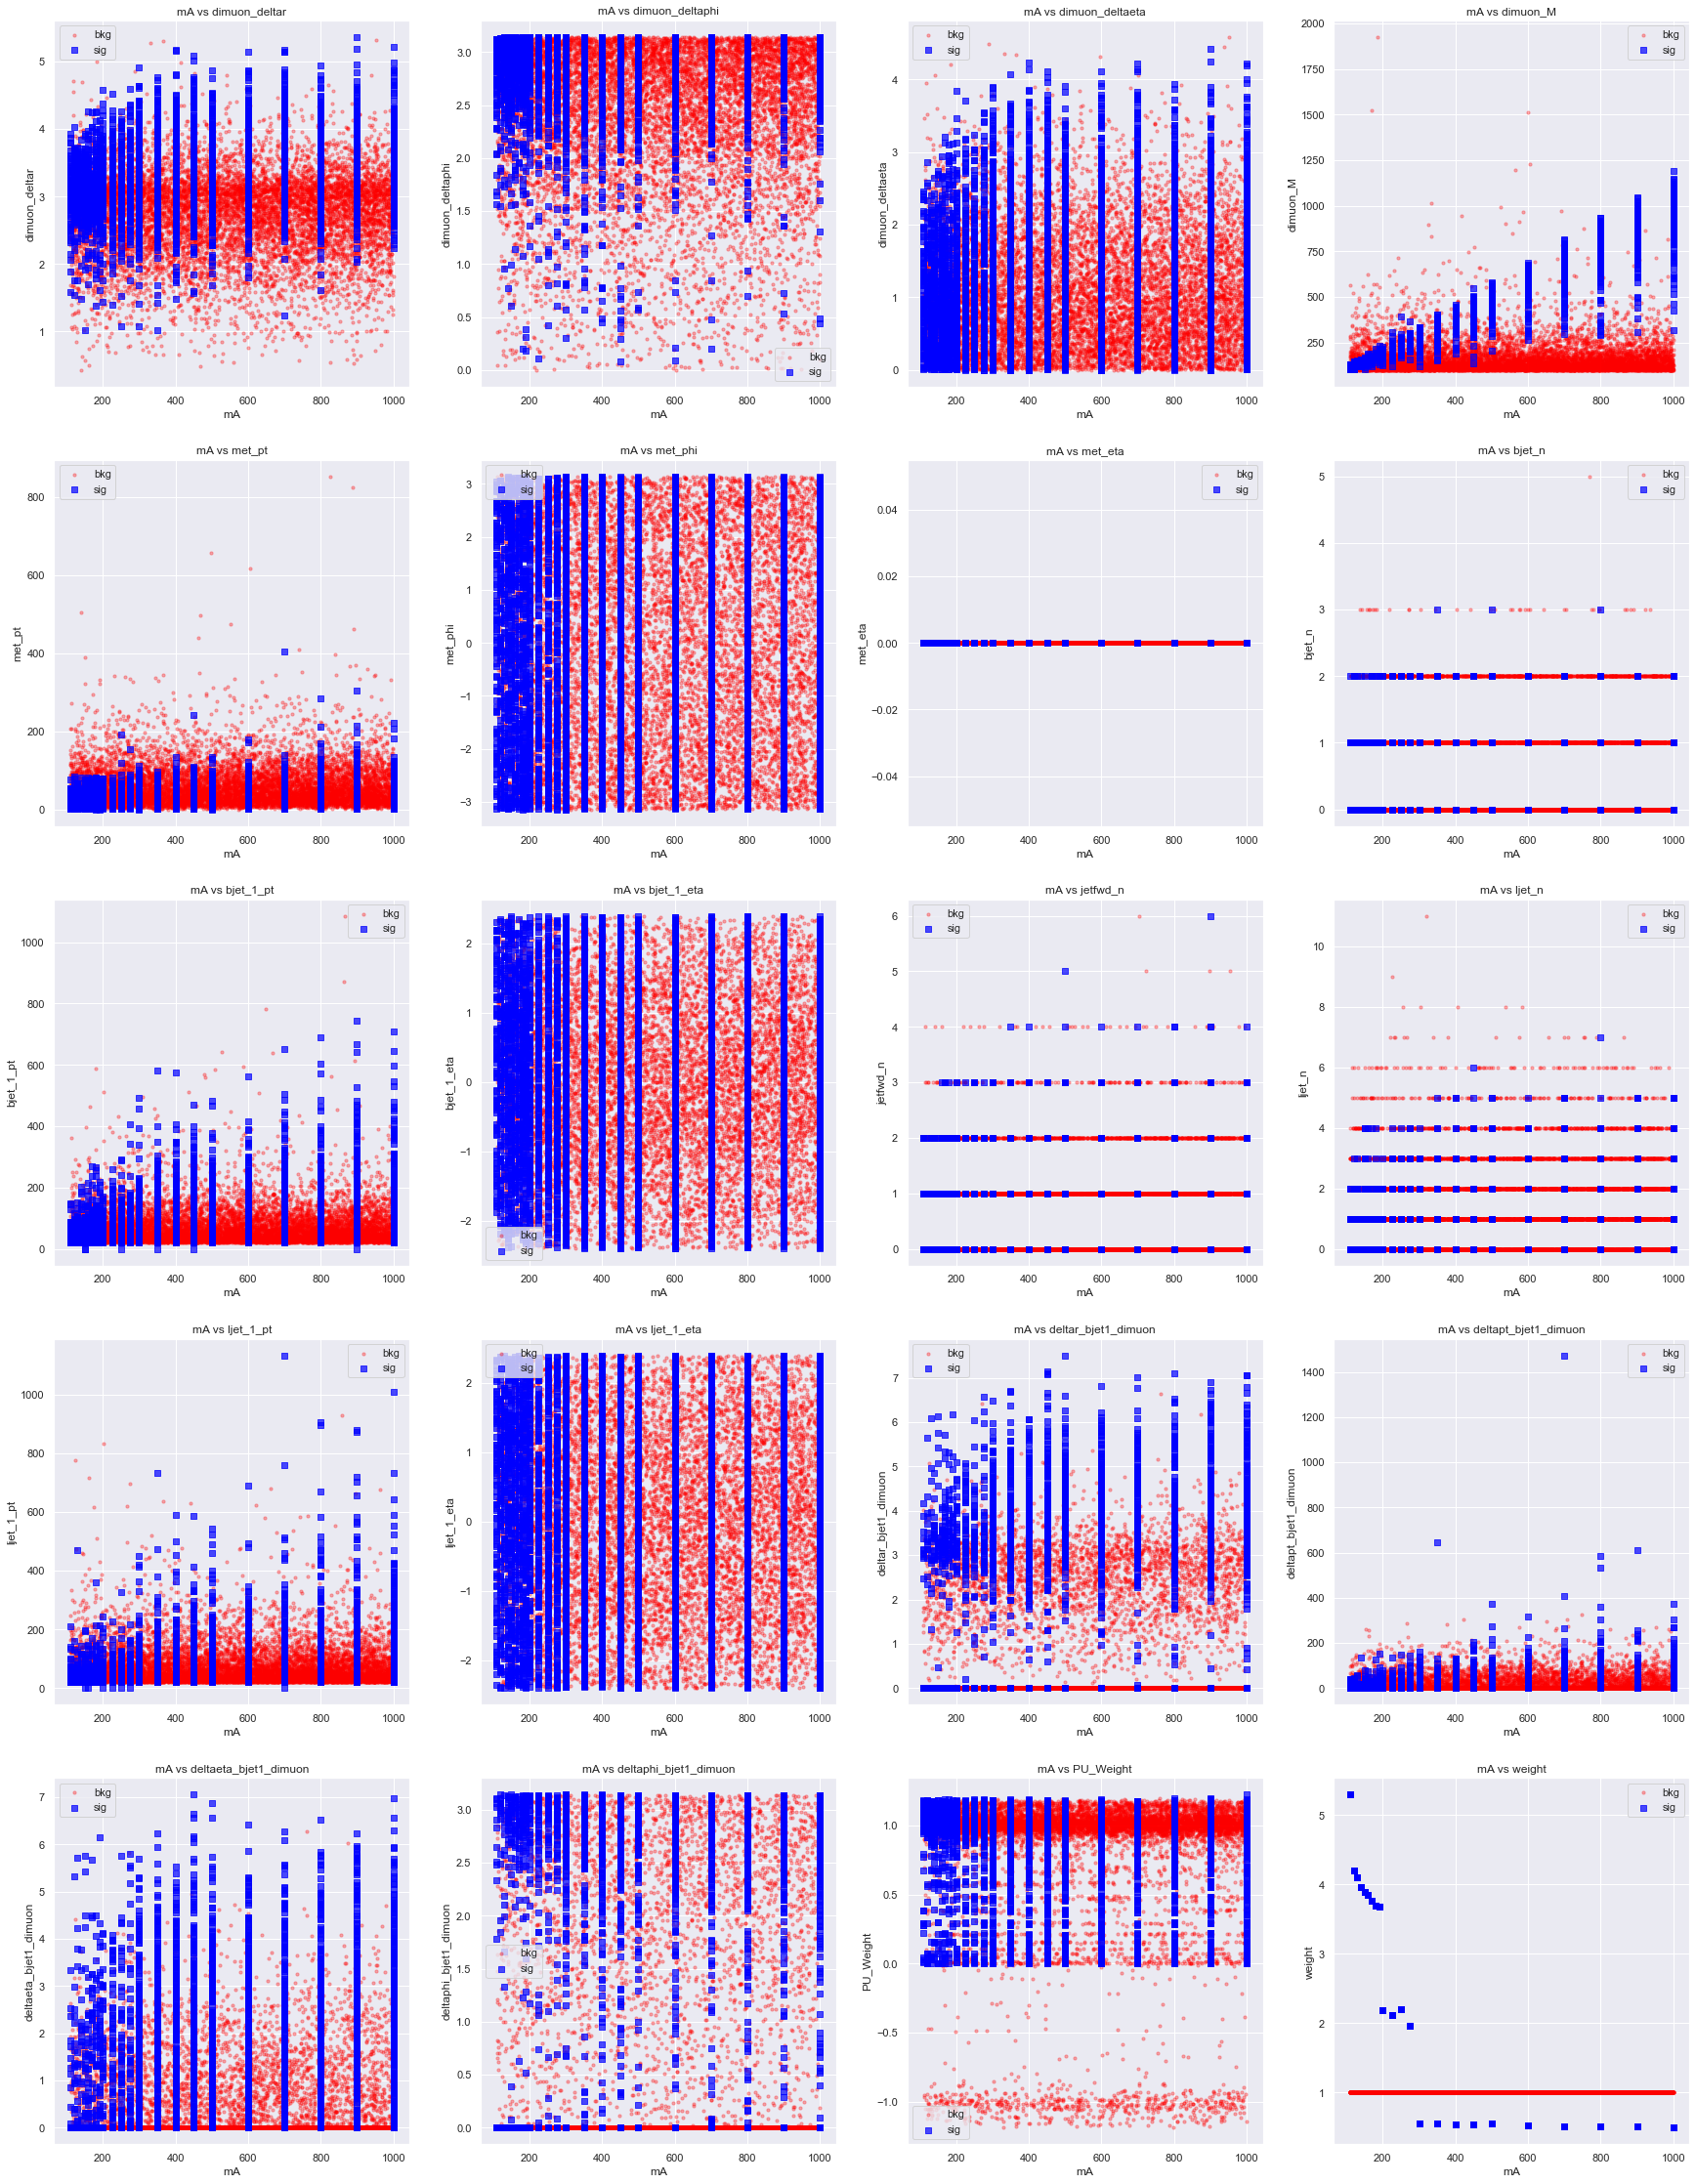

In [164]:
plt.figure(figsize=(30, 40))

for i, col in enumerate(columns):
    plt.subplot(5, 4, i + 1)
    scatter(col)

* [WIP] trying to do some 3D plots that show the distribution of a single feature for signal and bkg, w.r.t. the mass distribution

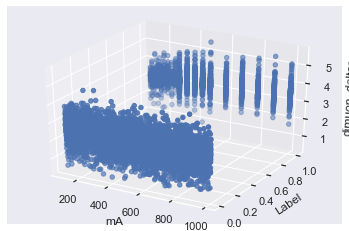

In [67]:
from mpl_toolkits.mplot3d import Axes3D

sample = data.ds.sample(10_000, random_state=SEED)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = sample['mA']
y = sample['type']
z = sample[columns[0]]

ax.set_xlabel('mA')
ax.set_ylabel('Label')
ax.set_zlabel(columns[0])

ax.scatter(x, y, z)

plt.show()

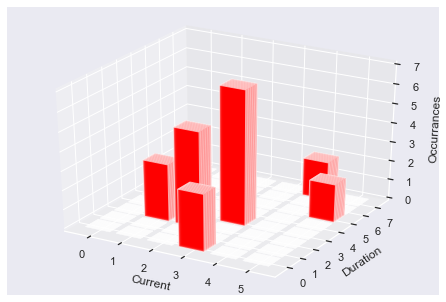

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
data = [ [0,0,0,3,0,0],
 [0,0,0,0,0,0],
 [0,3,5,0,0,0],
 [0,0,0,7,0,0],
 [0,0,0,0,0,0],
 [0,0,0,0,0,2],
 [0,0,0,0,0,0],
 [0,0,0,0,2,0] ]

fig = plt.figure()
ax = Axes3D(fig)
 
def plot3d(data, ax, barcolor):
    """ Takes in a matrix (see structure above) and generate a pseudo-3D histogram by overlaying close, semitransparent bars. """
    for duration, occurrence in zip(range(len(data)), data):
        current = range(len(occurrence))
        barband = range(-45, 45, 5)
        for modifier in barband:
            ax.bar(current, occurrence, zs=duration+(float(modifier)/100), zdir='y', color=barcolor, alpha=0.6)
 
    ax.set_xlabel('Current')
    ax.set_ylabel('Duration')
    ax.set_zlabel('Occurrances')
    

plot3d(data, ax, 'red')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

 
def plot3d(data, col, barcolor):
    """ Takes in a matrix (see structure above) and generate a pseudo-3D histogram by overlaying close, semitransparent bars. """
    fig = plt.figure()
    ax = Axes3D(fig)
    
    x = data['mA']
    y = data['type']
    z = data[col]
    
    for duration, occurrence in zip(y, z):
#         current = range(len(occurrence))  # = x
        barband = range(-45, 45, 5)
        
        for modifier in barband:
            ax.bar(x, occurrence, zs=duration + (float(modifier) / 100), zdir='y', color=barcolor, alpha=0.6)
 
    ax.set_xlabel('mA')
    ax.set_ylabel('Label')
    ax.set_zlabel(col)

    

plot3d(sample, columns[0], 'red')